# 📖 **Comparative Analysis of Literary Translations in the Odyssey: Lexical Diversity and Frequency Trends**

## 🔍 Research Objectives  
This notebook presents a **minimum viable product (MVP)** for a larger research project the exploring lexical diversity, syntactic qualities, stylometric features, and thematic mapping of different literary translations of the Odyssey (~30 versions across four centuries). **This MVP focuses on lexical analysis of a couple of translations**. The goal is to **test methods and materials** rather than reach definitive conclusions.  

The workflow follows a **modular structure**, encompassing:  
- **Text collection & libraries**  
- **Lexical diversity experiments**  
- **Statistical hypothesis testing**  
- **Discussion of preliminary findings**  

For this iteration, we analyze **two modern English translations** of *The Odyssey*:  
➡️ **Emily Wilson's translation, 2017**  
➡️ **Peter Green's translation, 2018**  

---

## 🛤️ Methodology Roadmap (Table of Contents)  

### 1️⃣ Libraries & Text Acquisition  
📌 Setting up the environment and loading texts.  

### 2️⃣ Experiment 1: **Type-Token Ratio (TTR)**  
- 📌 **Implementation:** Computing TTR for both translations.  
- 📊 **Parametric Hypothesis Testing:** Comparing TTR statistically.  

### 3️⃣ Experiment 2: **Zipf’s Law Verification**  
- 📌 **Implementation:** Examining word frequency distributions.  
- 📊 **Parametric Hypothesis Testing:** Evaluating Zipfian behavior.  

### 4️⃣ Experiment 3: **TF-IDF Analysis**  
- 📌 **Implementation:** Identifying key lexical differences.  
- 📊 **NOn-Parametric Hypothesis Testing:** Assessing significant variations.  

### 5️⃣ Discussion of Results  
- 🔎 **Findings:** Insights from experiments.  
- 🚀 **New Directions:** Refinements & future research steps.  

____________________________________________________
## 1️⃣ Libraries & Text Acquisition 

In [1]:
# Libraries
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import numpy as np
import re
import sys
import os
tqdm.pandas()

In [2]:
# Visualization
%matplotlib inline

# Add the directory containing visualization_utils.py to path
sys.path.append("/Users/debr/English-Homer/")
import visualization_utils as viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
# palette astroblue   orange   genoa      carrot    tawny     neptune      SELAGO    mako   black
color = ['#003D59', '#FD6626','#177070','#FB871D','#641B5E','#86C3BC','#F5E1FD','#414A4F','k']
danB_plotstyle = {'figure.figsize': (12, 7), 
               'axes.labelsize': 'large', # fontsize for x and y labels (was large)
               'axes.titlesize': 'large', # fontsize for title
               'axes.titleweight': 'bold', # font type for title
               'xtick.labelsize': 'large', # fontsize for x 
               'ytick.labelsize':'small', # fontsize fory ticks
               'grid.color': 'k', # grid color
                'grid.linestyle': ':', # grid line style
                'grid.linewidth': 0.2, # grid line width
                'font.family': 'Times New Roman', # font family
                'grid.alpha': 0.5, # transparency of grid
               'figure.dpi': 300, # figure display resolution
               'savefig.bbox': 'tight', # tight bounding box
               'savefig.pad_inches': 0.4, # padding to use when saving
               'axes.titlepad': 15, # title padding
               'axes.labelpad': 8, # label padding
               'legend.borderpad': .6, # legend border padding
               'axes.prop_cycle': plt.cycler(
                color=color) # color cycle for plot lines
               }

# adjust matplotlib defaults
plt.rcParams.update(danB_plotstyle)

In [3]:
# Load CSVs
filepath_Wilson = "/Users/debr/odysseys_en/Odyssey_dfs/Odyssey_Wilson_eda_END.csv"
filepath_Green = "/Users/debr/odysseys_en/Odyssey_dfs/Odyssey_Green_eda_END.csv"

df_W = pd.read_csv(filepath_Wilson)
df_G = pd.read_csv(filepath_Green)

# Add translation label
df_W["translation"] = "Wilson"
df_G["translation"] = "Green"

# merging "book_num" with "translation" to create a unique identifier
df_W["book_id"] = df_W["book_num"].astype(str) + "_W"
df_W = df_W.drop(columns=["book_num"])
df_G["book_id"] = df_G["book_num"].astype(str) + "_G"
df_G = df_G.drop(columns=["book_num"])

# Keep only necessary columns: book number & tokens
df_W = df_W[["translation", "book_id", "tokens"]]
df_G = df_G[["translation", "book_id", "tokens"]]

# Combine both into one DataFrame
df = pd.concat([df_W, df_G], ignore_index=True)

# Ensure tokens are stored as lists (if stored as strings, convert them)
df["tokens"] = df["tokens"].apply(lambda x: eval(x) if isinstance(x, str) else x)

In [4]:
#Boolean check for missing values
if df.isna().sum().sum() == 0:
    print("No missing values")
else:
    for col in df.columns:
        if df[col].isna().sum() > 0:
            print(f"Missing values in {col}")
print("df columns:", df.columns, "shape:", df.shape)

No missing values
df columns: Index(['translation', 'book_id', 'tokens'], dtype='object') shape: (48, 3)


In [5]:
df.head(2)

,translation,book_id,tokens
0,Wilson,1_W,"[tell, complicated, man, muse, tell, wandered,..."
1,Wilson,2_W,"[dangerous, journey, early, dawn, born, finger..."


____________________________________________________
## 2️⃣ Experiment 1: **Type-Token Ratio (TTR)** 

# 📖 Lexical Diversity in *The Odyssey*: A Comparative Analysis of Green and Wilson’s Translations  

## ✨ Introduction  

**Type-Token Ratio (TTR)** is a key measure of lexical diversity, calculated as the number of unique words (**types**) divided by the total word count (**tokens**). It provides insight into a translator’s lexical choices when rendering the same source text.  

- A **higher TTR** suggests a richer vocabulary, possibly reflecting an effort to capture nuances or stylistic complexity.  
- A **lower TTR** may indicate a more repetitive or constrained word choice, potentially prioritizing accessibility or fidelity to the original.  

### 📌 **TTR Formula**  

$$TTR = \left( \frac{\text{Unique Words}}{\text{Total Words}} \right) \times 100$$  


---

## 🎯 Hypothesis Testing  

To compare **Green and Wilson’s translations**, we define the following hypotheses:  

- **H₀ (Null Hypothesis):** No significant difference in lexical diversity between the translations.  
- **H₁ (Alternative Hypothesis):** A significant difference in lexical diversity exists.  

### 📊 **Statistical Approach**  

We employ a **t-test** to determine whether observed TTR differences are statistically meaningful:  

✅ If **p-value < 0.05**, we **reject H₀**, indicating a significant lexical difference.  
❌ If **p-value ≥ 0.05**, we **fail to reject H₀**, suggesting variations are not statistically significant.  

---

## 🔍 Implications for Translation Studies  

A significant difference in TTR may reveal:  

1️⃣ **Divergent translation strategies** (e.g., formal vs. dynamic equivalence)  
2️⃣ **Target audience considerations** (academic vs. general readership)  
3️⃣ **Temporal influences** (stylistic shifts over time––which in this instance it cannot be a decisive factor because they have been published just one year appart)  
4️⃣ **Translator’s individual style and lexical preferences**  
5️⃣ **Varying interpretations of the original text’s tone and meaning**  

This **quantitative analysis** serves as an empirical foundation for **qualitative exploration** of how Green and Wilson shape *The Odyssey’s* language, structure, and poetic essence.  

---

📌 *This study provides an objective lens to compare translation styles, enriching our understanding of literary interpretation in classical texts.*  

In [6]:
# Compute type-token ratio (TTR) for each book

import scipy.stats as stats

# Compute TTR
df["ttr"] = df["tokens"].apply(lambda x: len(set(x)) / len(x) if x else 0)

# Separate TTRs for the two translations
ttr_wilson = df[df["translation"] == "Wilson"]["ttr"].tolist()
ttr_green = df[df["translation"] == "Green"]["ttr"].tolist()
#ttr_wilson = df[df["book_id"].str.endswith("W")]["ttr"].tolist() # Wilson --Alternative:ttr_wilson = df[df["book_id"].str[-1] == "W"]["ttr"].tolist() 
#ttr_green = df[df["book_id"].str.endswith("G")]["ttr"].tolist # Green --Alternative: ttr_green = df[df["book_id"].str[-1] == "G"]["ttr"].tolist()


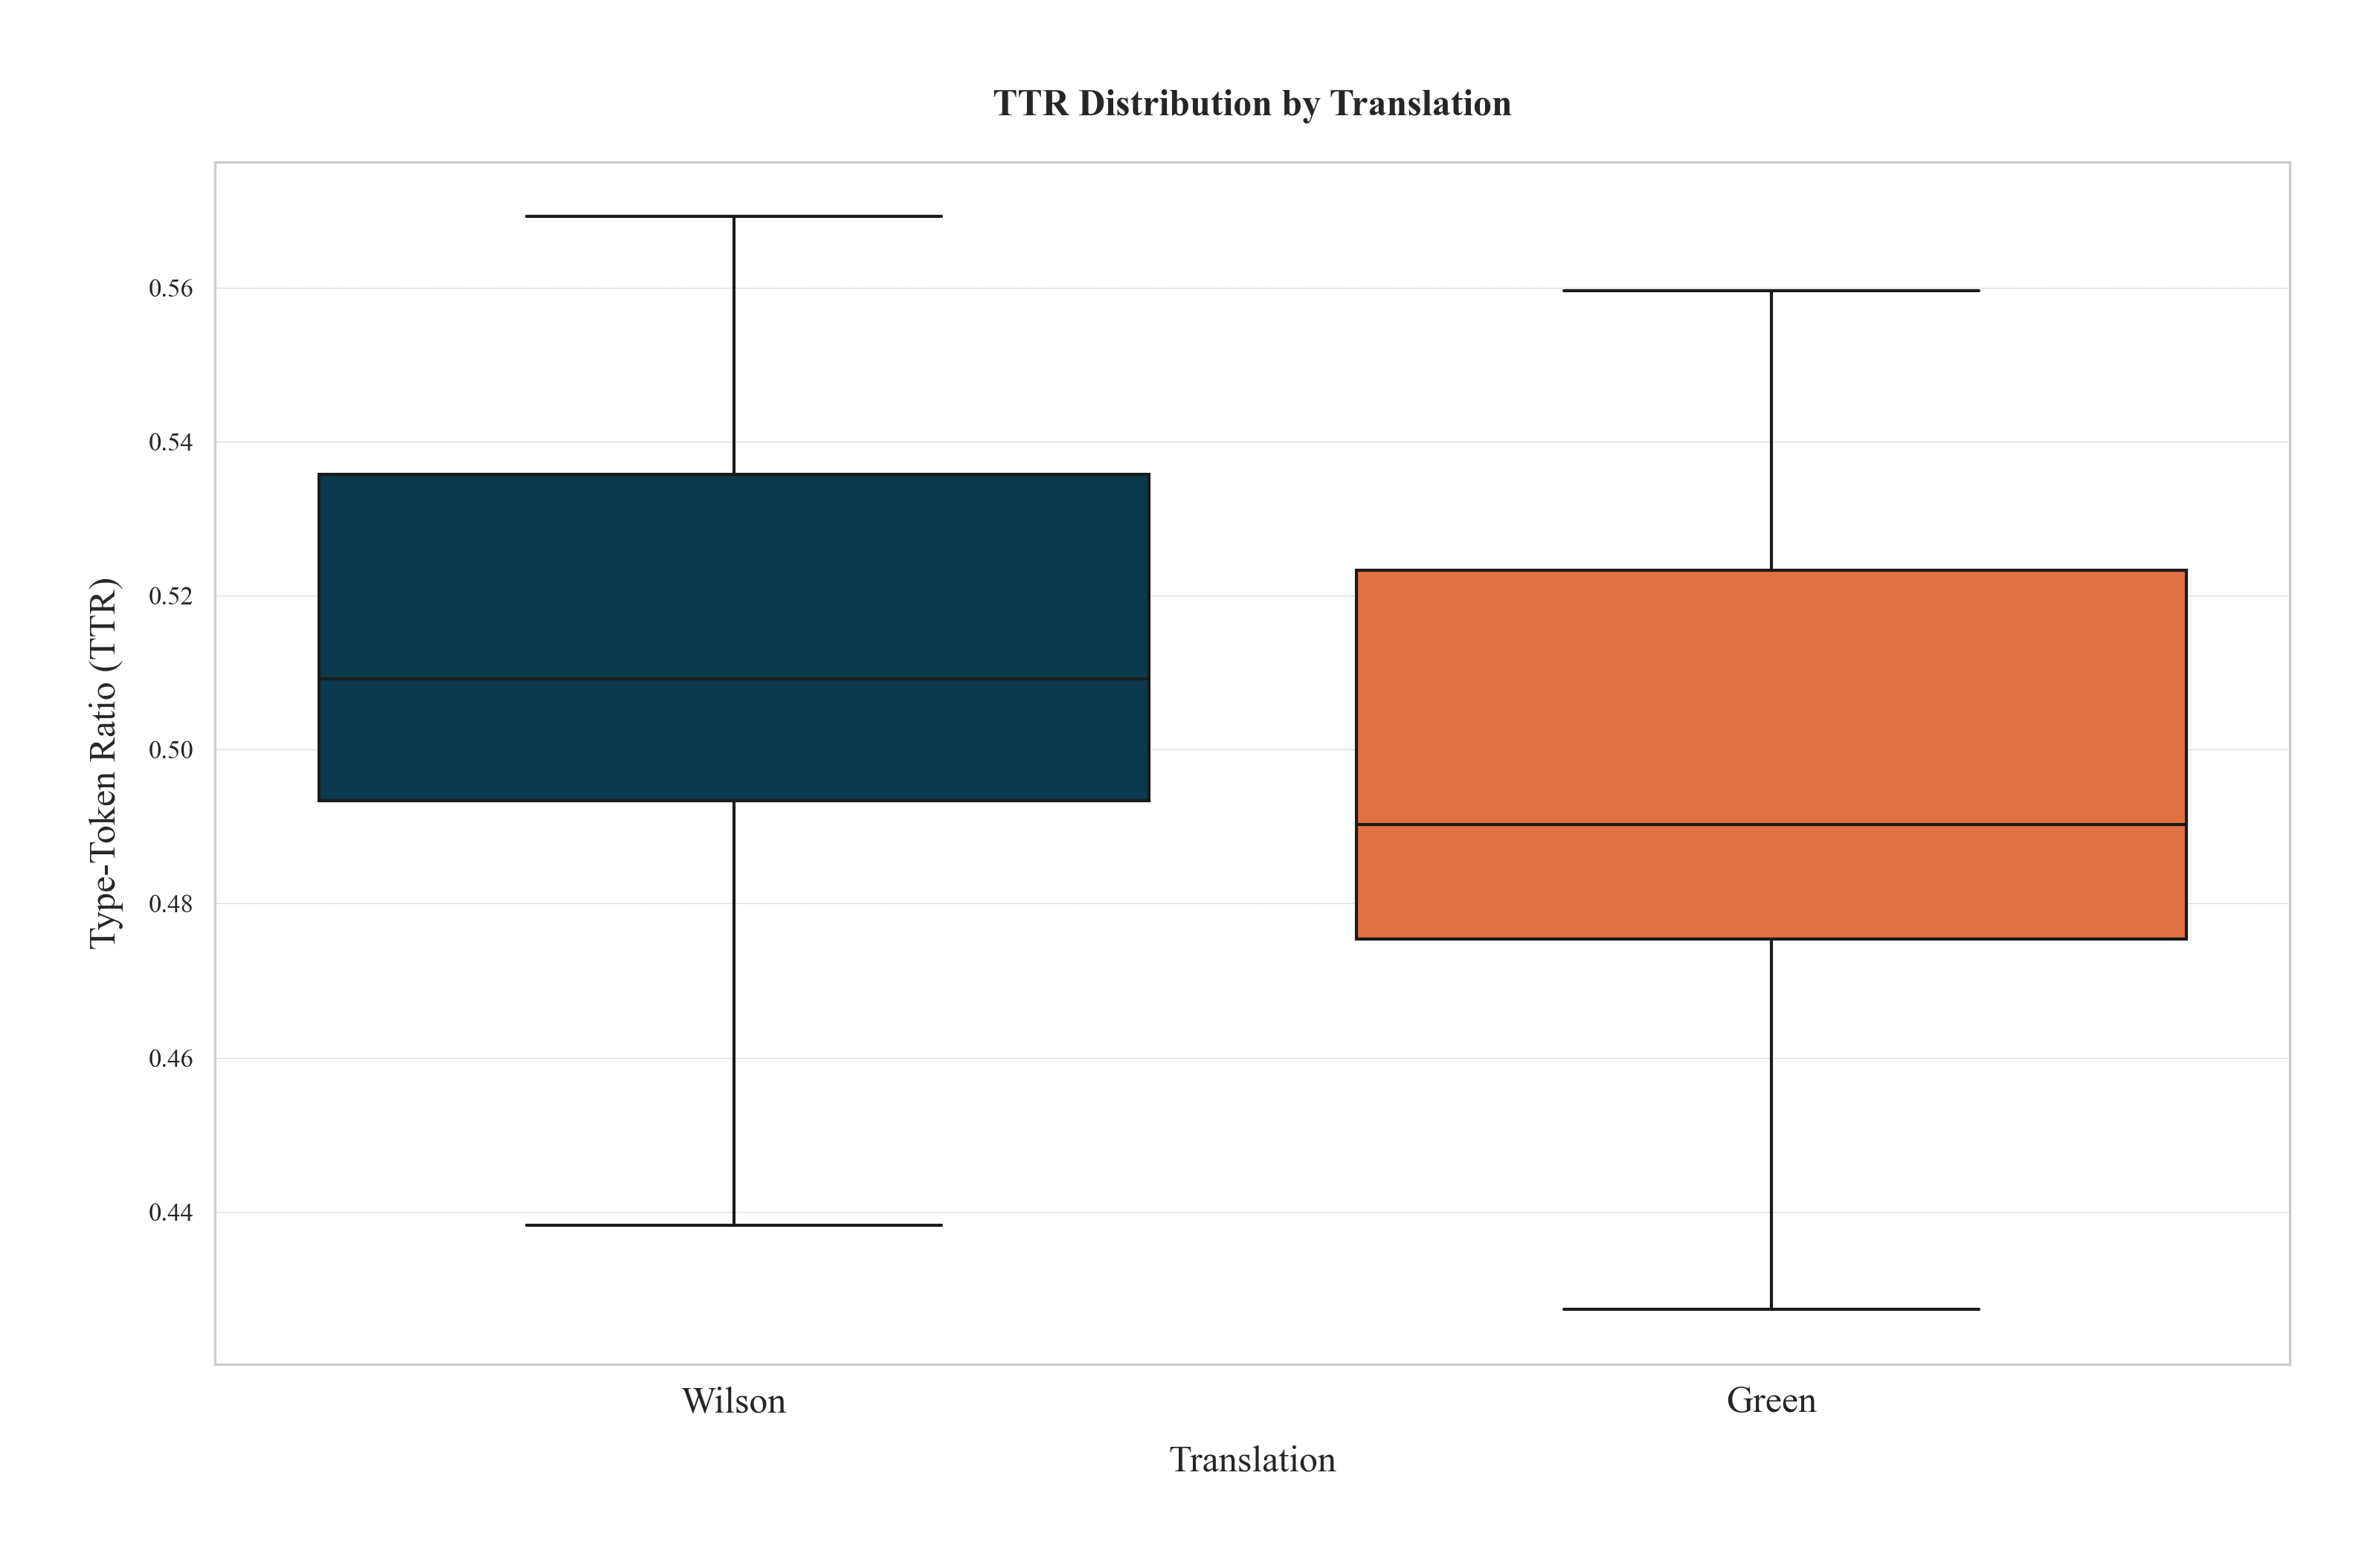

In [7]:
# Create a boxplot for TTR values
sns.boxplot(x=df["translation"], y=df["ttr"], palette=color)
plt.title("TTR Distribution by Translation")
plt.xlabel("Translation")
plt.ylabel("Type-Token Ratio (TTR)")
plt. savefig("/Users/debr/English-Homer/MVP_Green-Wilson/MVP_plots/MVP-TTR_distribution.png")
plt.show()

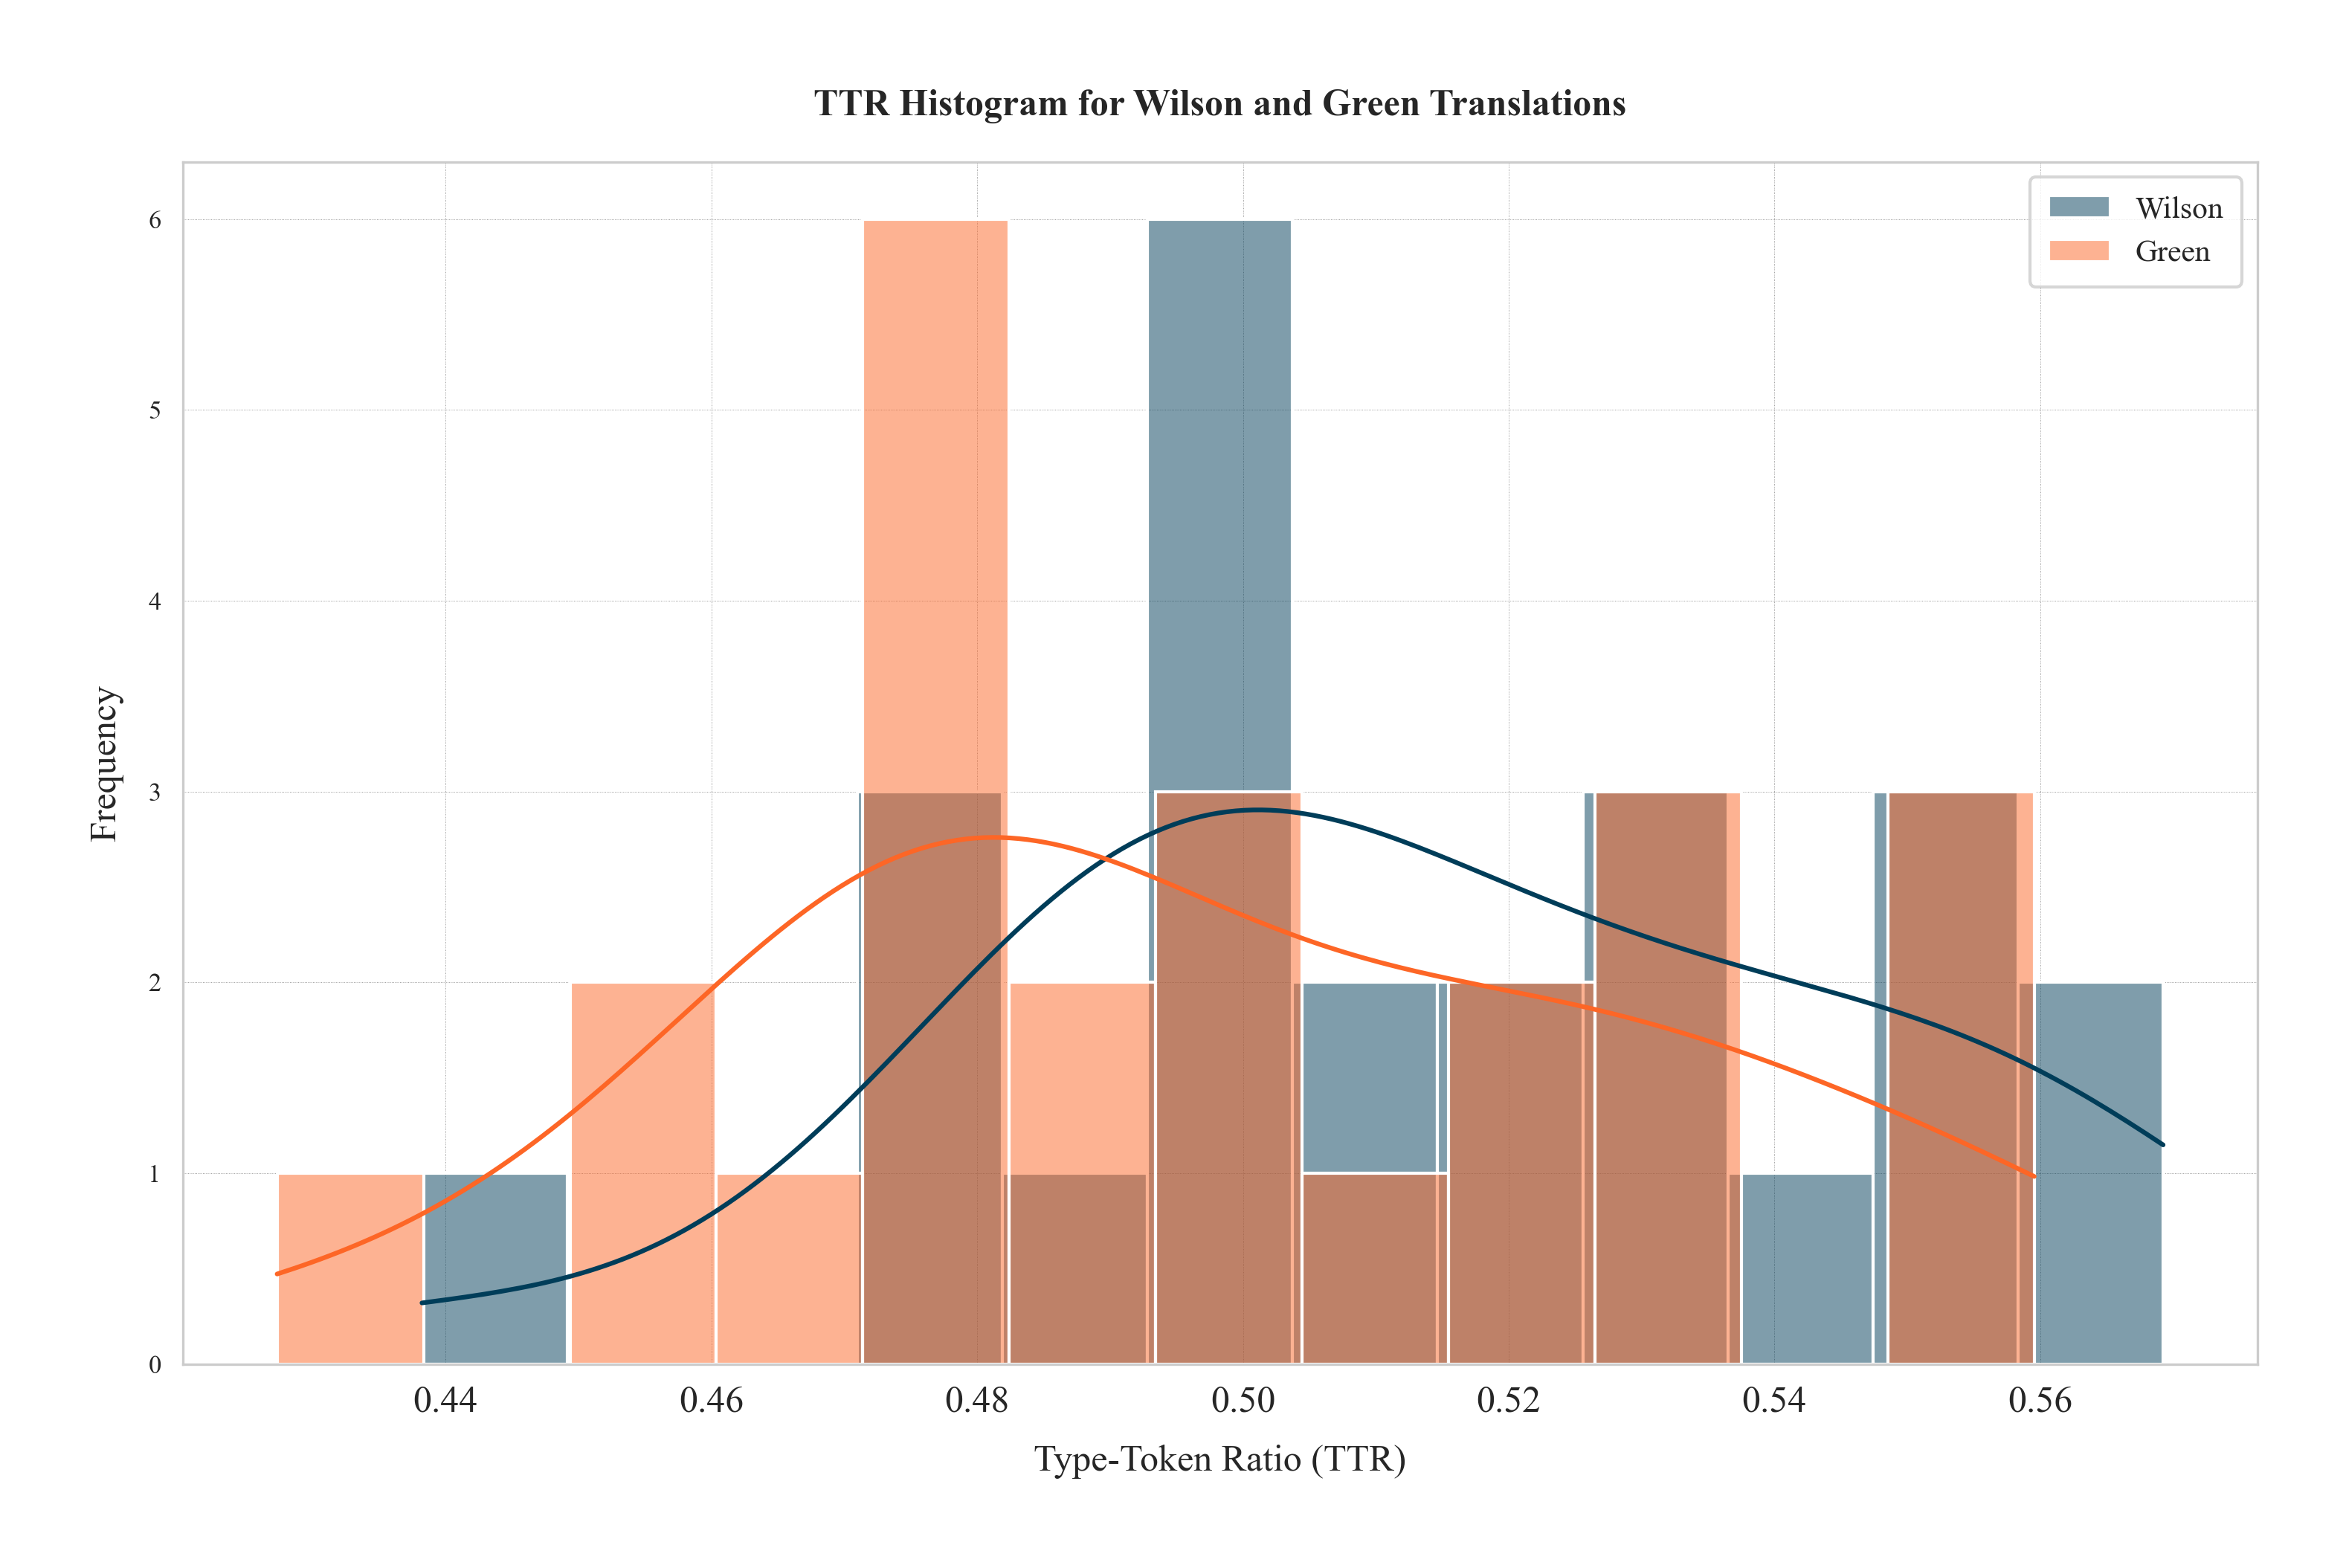

In [8]:
# Create a histogram for TTR values
# Plot histogram for Wilson and Green translations
sns.histplot(ttr_wilson, bins=12, label="Wilson", kde=True, alpha=0.5)
sns.histplot(ttr_green, bins=12, label="Green", kde=True, alpha=0.5)
# Add labels and legend
plt.title("TTR Histogram for Wilson and Green Translations")
plt.xlabel("Type-Token Ratio (TTR)")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("/Users/debr/English-Homer/MVP_Green-Wilson/MVP_plots/MVP-TTR_histogram.png")
plt.show()

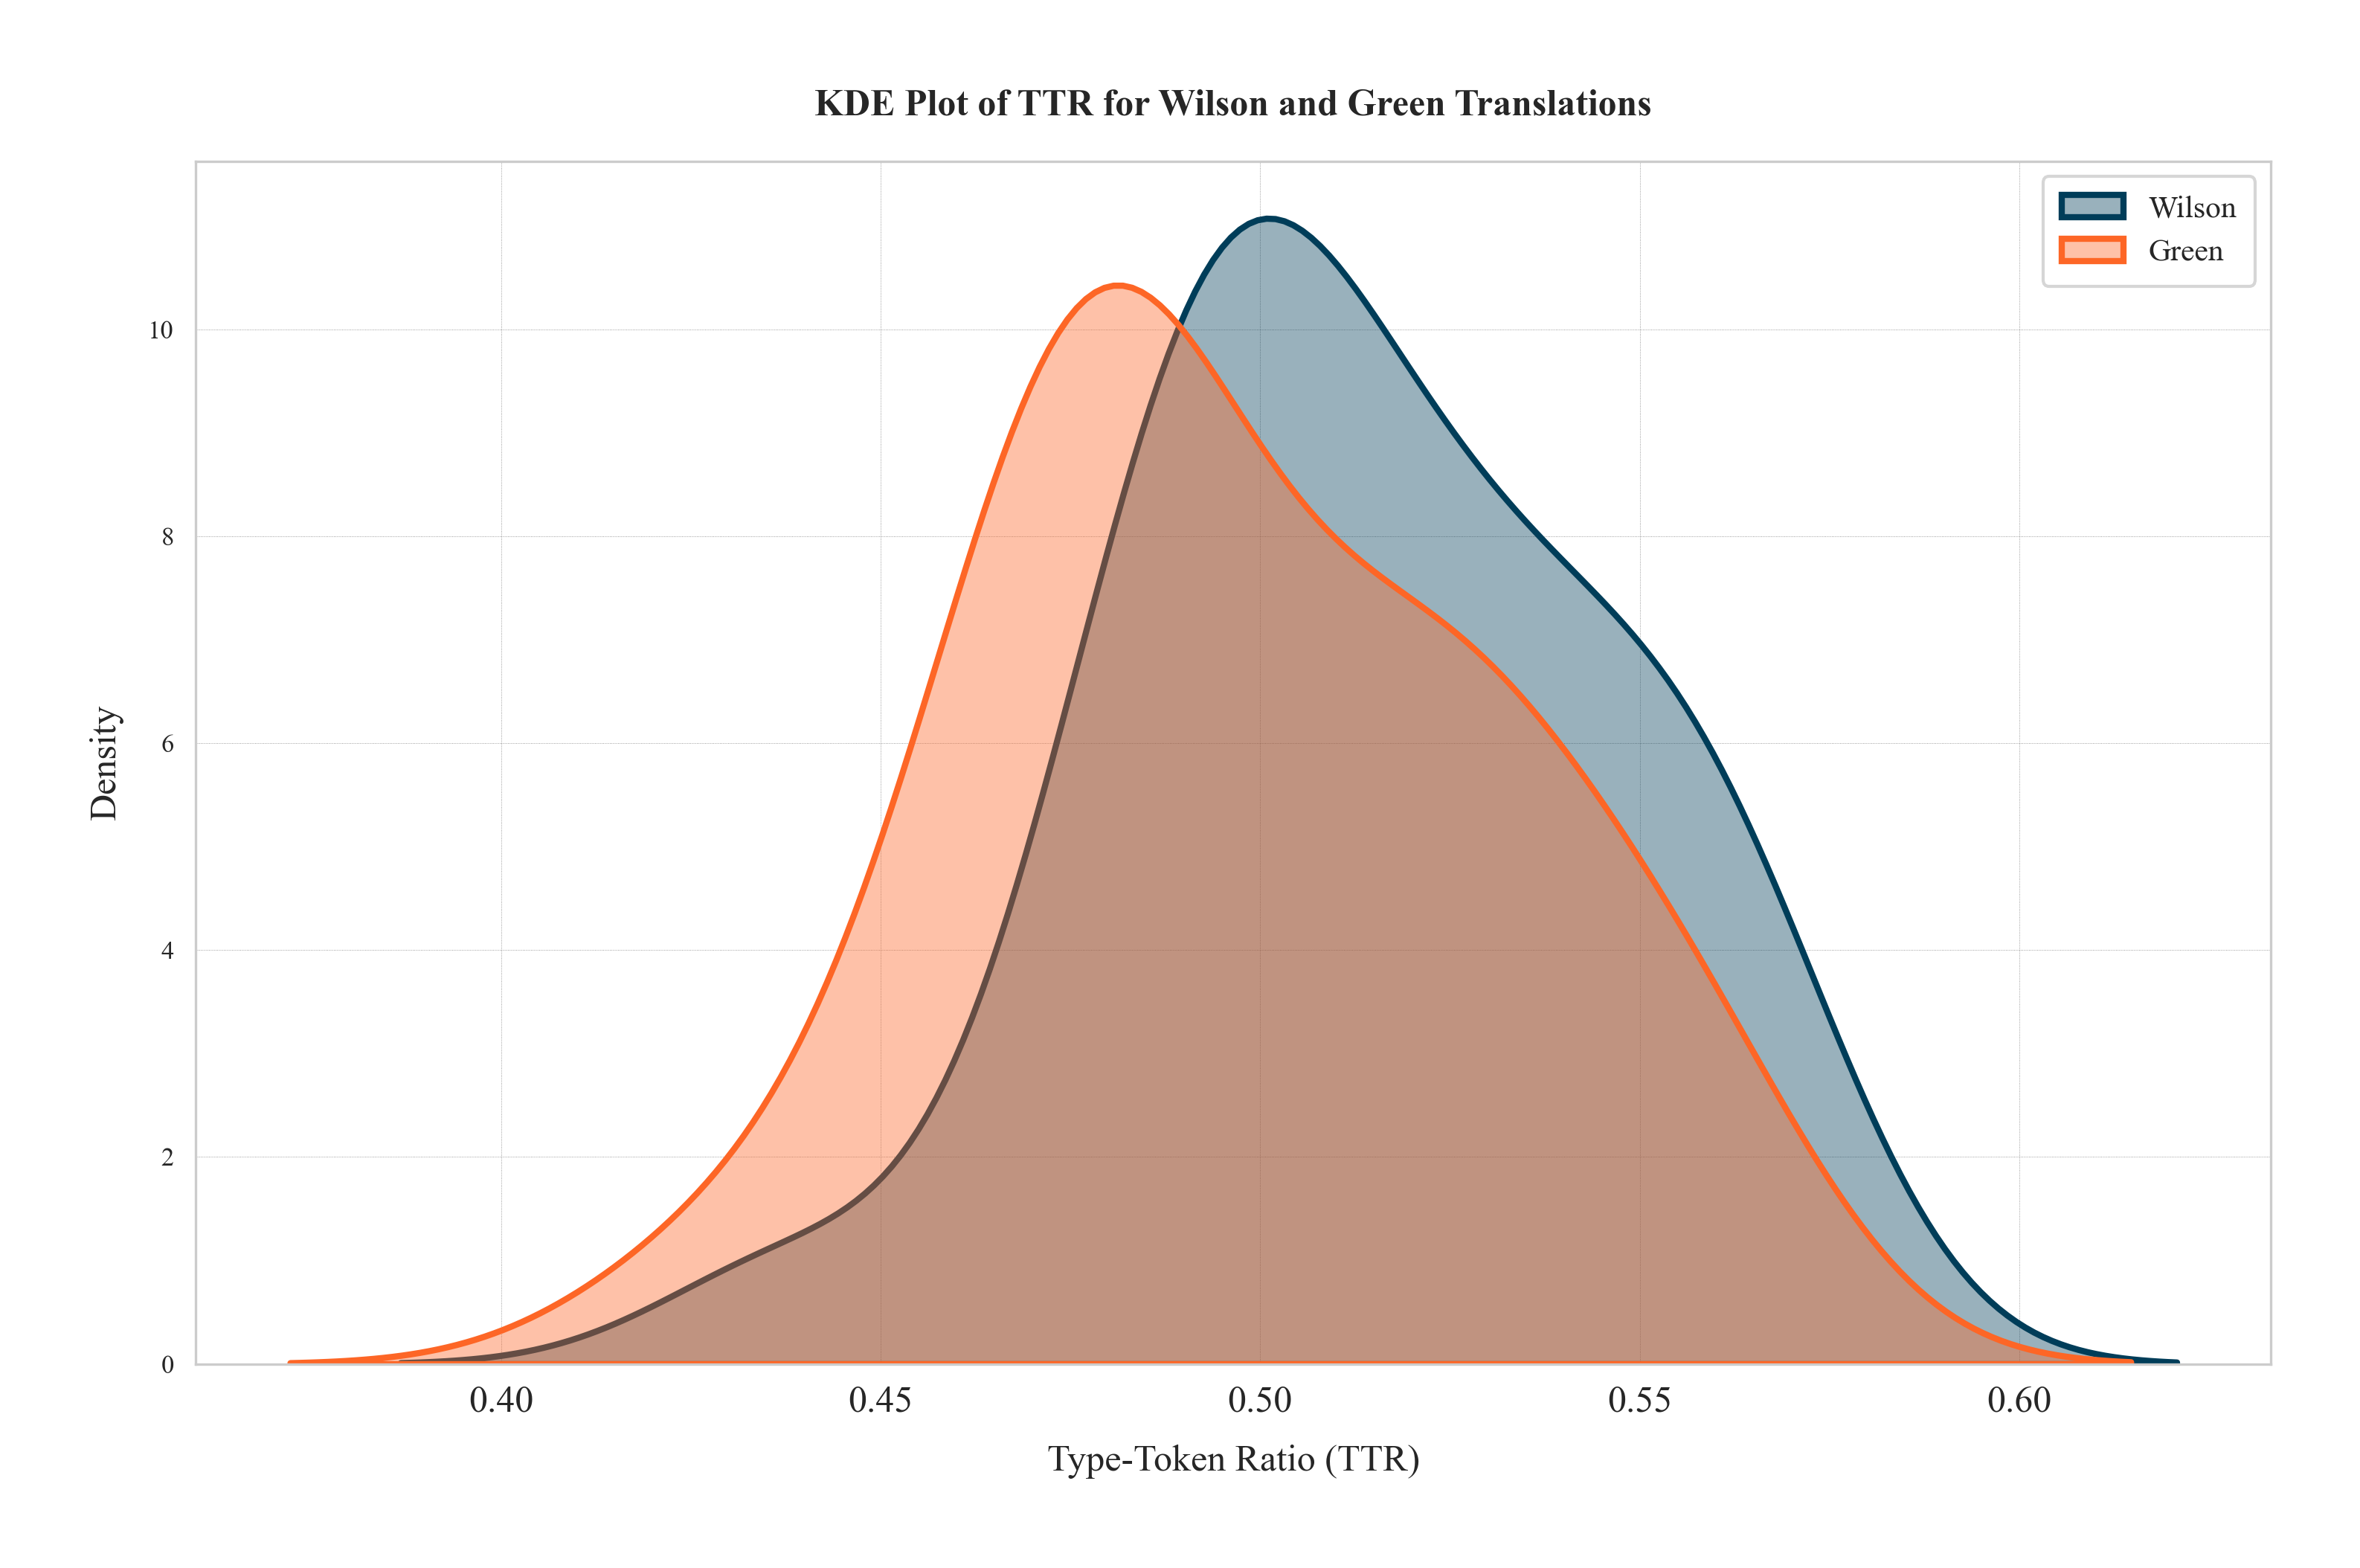

In [9]:
# KDE plot for Wilson and Green translations
sns.kdeplot(ttr_wilson, fill=True, label="Wilson", alpha=0.4, linewidth=2)
sns.kdeplot(ttr_green, fill=True, label="Green", alpha=0.4, linewidth=2)

plt.title("KDE Plot of TTR for Wilson and Green Translations")
plt.xlabel("Type-Token Ratio (TTR)")
plt.ylabel("Density")
plt.legend()
plt.savefig("/Users/debr/English-Homer/MVP_Green-Wilson/MVP_plots/MVP-TTR_kdeplot.png")
plt.show()

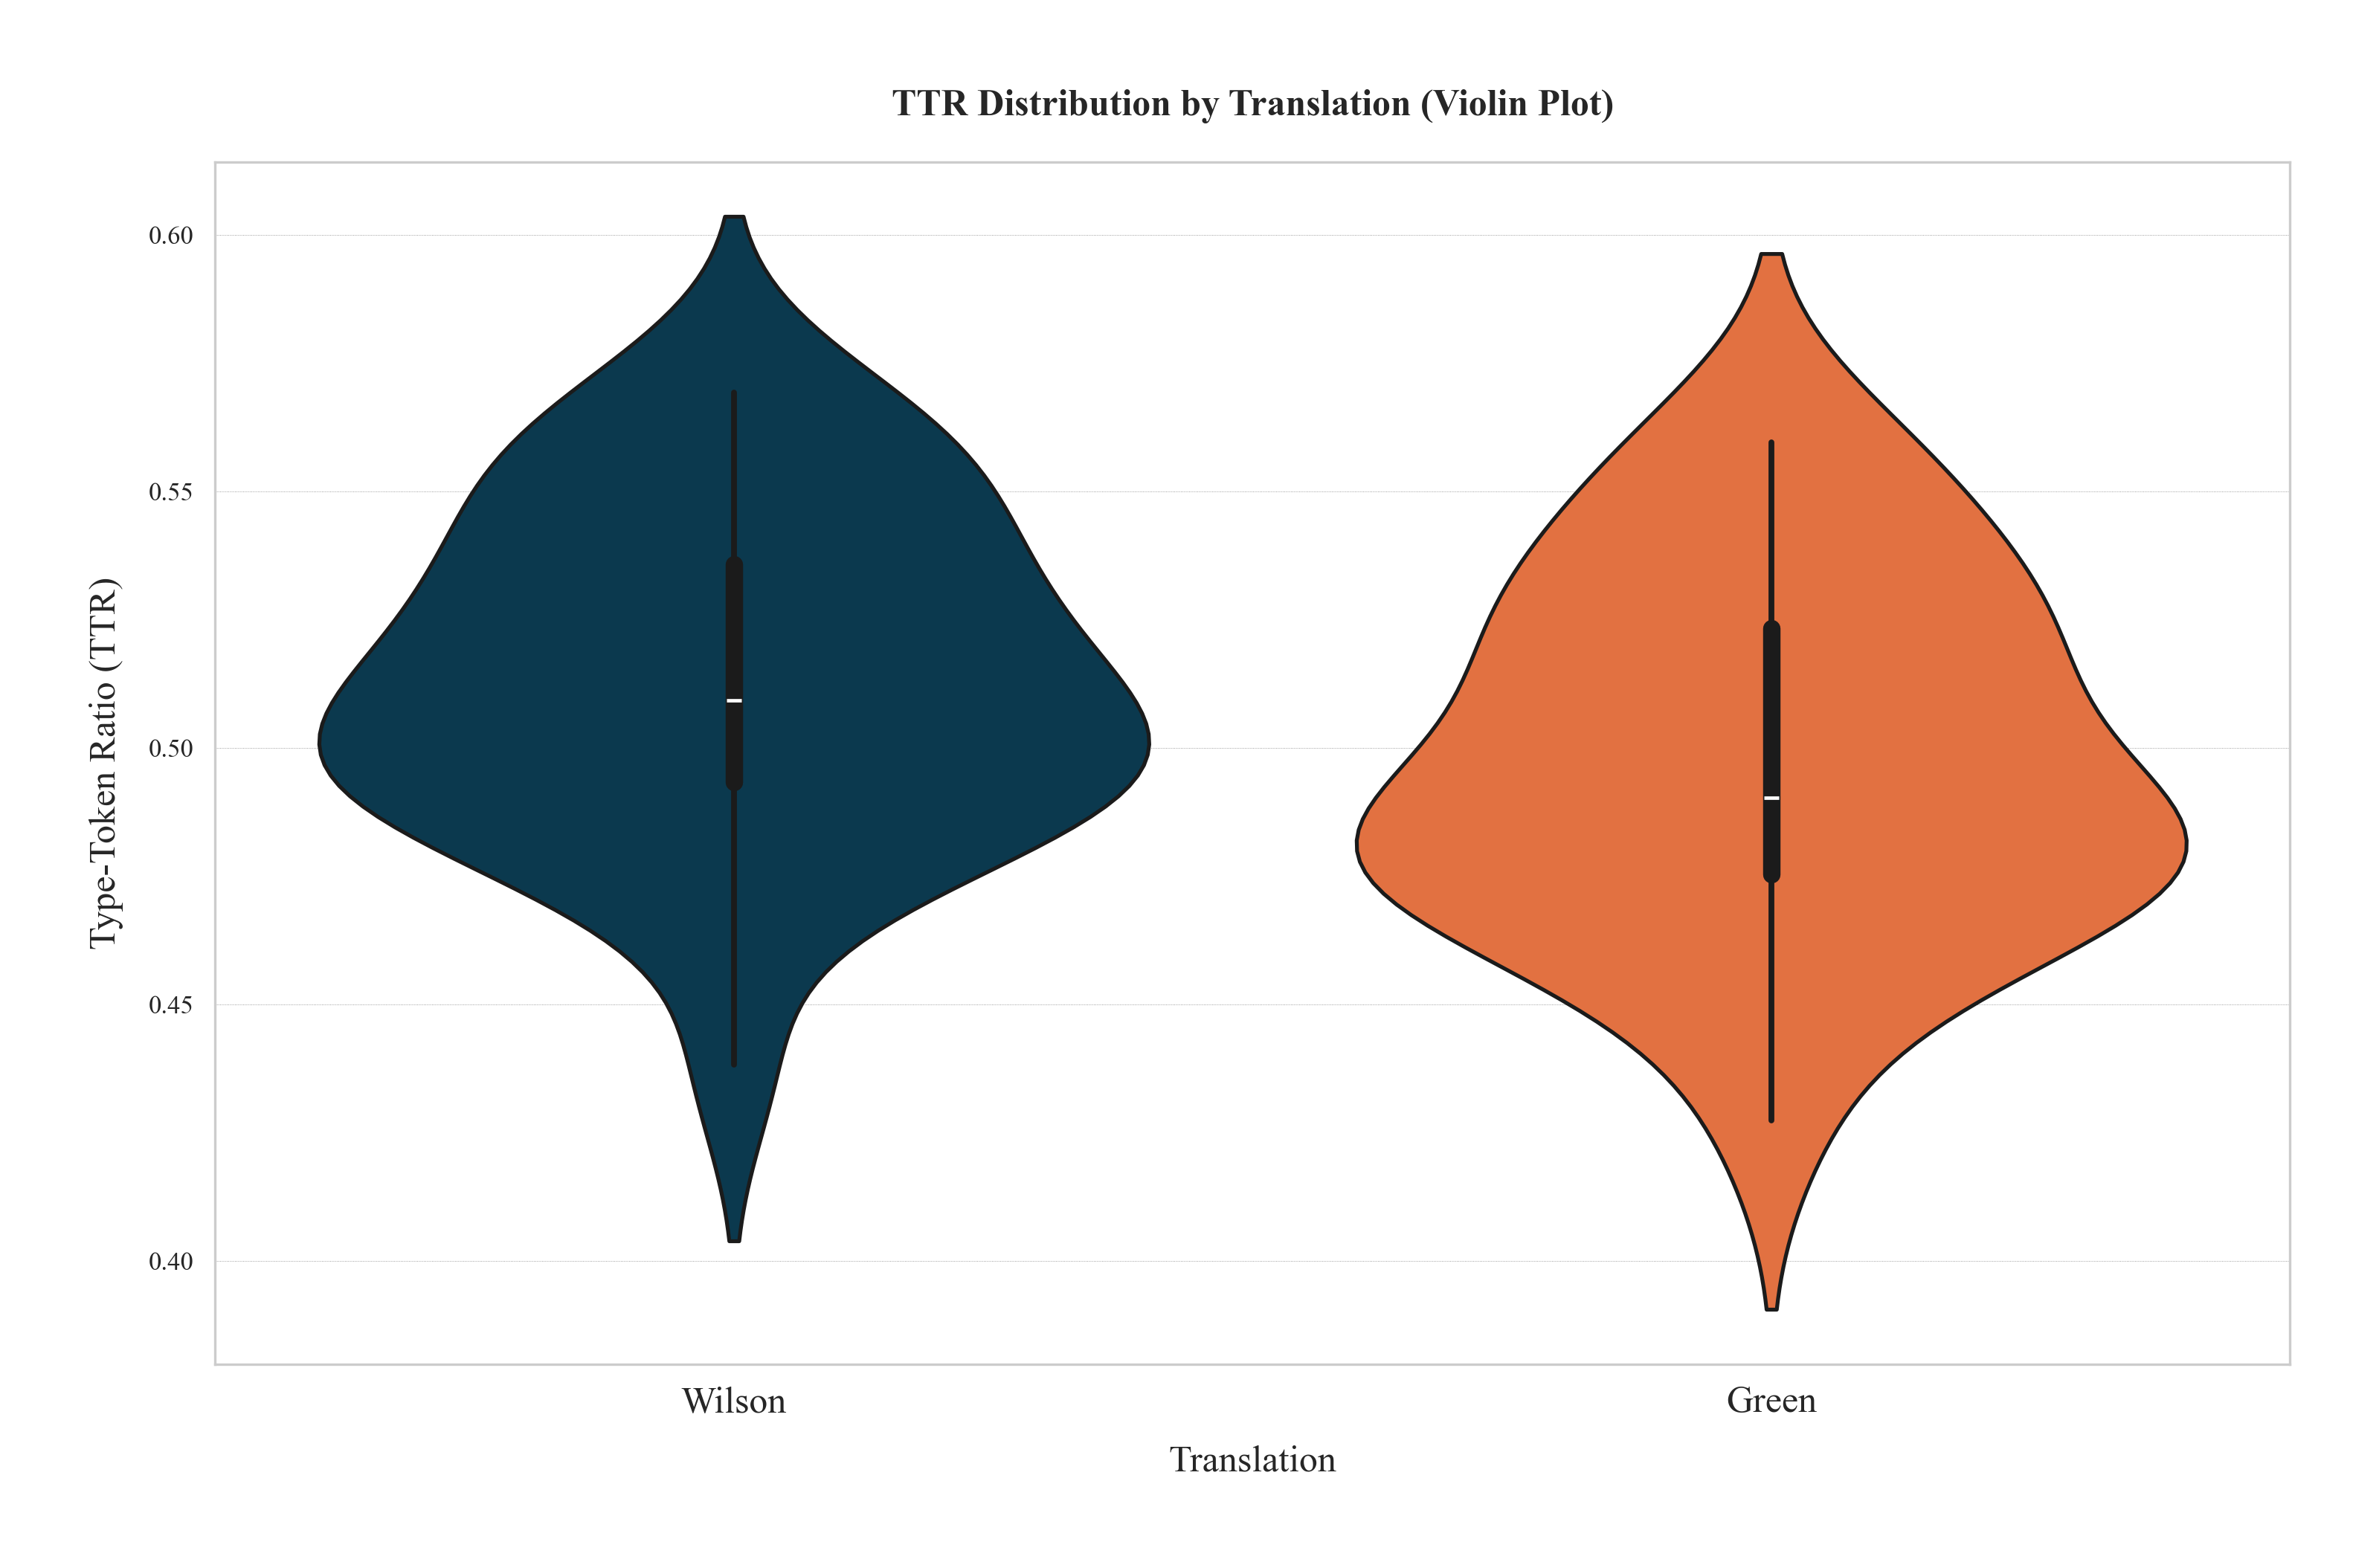

In [10]:
# Create a violin plot for TTR values
sns.violinplot(x=df["translation"], y=df["ttr"], palette=color)
plt.title("TTR Distribution by Translation (Violin Plot)")
plt.xlabel("Translation")
plt.ylabel("Type-Token Ratio (TTR)")
plt.savefig("/Users/debr/English-Homer/MVP_Green-Wilson/MVP_plots/MVP-TTR_violinplot.png")
plt.show()

In [11]:
from scipy import stats

# Shapiro-Wilk test for ttr_wilson (for Wilson's data)
stat_wilson, p_value_wilson = stats.shapiro(ttr_wilson)
print(f"Shapiro-Wilk test for Wilson's data: T-statistic={stat_wilson}, p-value={p_value_wilson}")

# Shapiro-Wilk test for ttr_green (for Green's data)
stat_green, p_value_green = stats.shapiro(ttr_green)
print(f"Shapiro-Wilk test for Green's data: T-statistic={stat_green}, p-value={p_value_green}")

# Interpretation of p-values
if p_value_wilson < 0.05:
    print("Wilson's TTR data is not normally distributed.")
else:
    print("Wilson's TTR data is normally distributed.")

if p_value_green < 0.05:
    print("Green's TTR data is not normally distributed.")
else:
    print("Green's TTR data is normally distributed.")

Shapiro-Wilk test for Wilson's data: T-statistic=0.9710503976522772, p-value=0.6929667067088071
Shapiro-Wilk test for Green's data: T-statistic=0.9647758095190286, p-value=0.541526201743056
Wilson's TTR data is normally distributed.
Green's TTR data is normally distributed.


In [12]:
# Perform t-test
t_stat, p_value = stats.ttest_ind(ttr_wilson, ttr_green)
print(f"T-statistic: {t_stat}, P-value: {p_value}")
if p_value < 0.05:
    print("The difference in TTR between Wilson and Green is statistically significant.")
else:
    print("The difference in TTR between Wilson and Green is not statistically significant.")

T-statistic: 1.6455514452077802, P-value: 0.10667311090438025
The difference in TTR between Wilson and Green is not statistically significant.


### 📖 **Discussion of Type-Token Ratio (TTR) in Green and Wilson’s Translations**

📊 **Statistical Findings and Interpretation**

The t-test comparing TTR values between Wilson’s and Green’s translations found no statistically significant difference (p ≥ 0.05). This supports the null hypothesis (H₀): their lexical diversity is quantitatively similar. Rather than being inconclusive, this result provides a crucial insight:

**Both translators operate within the same cultural and linguistic framework, which strongly influences their word choices.**

🌍 **Cultural Influence on Translation Choices**

The TTR similarity suggests that, despite stylistic differences, Green and Wilson share a common cultural foundation that shapes their translations. This is evident in:

🔹 Shared Linguistic Resources – Access to the same dictionaries, corpora, and reference materials.
🔹 Common Translation Norms – Adherence to contemporary literary and academic standards.
🔹 Target Audience Expectations – Catering to modern readers with similar readability preferences.
🔹 Influence of Translation Theories – Both working within dominant theoretical frameworks of their time.

🎭 **Beyond Numerical Similarity: The Art of Translation**

While TTR values are alike, this does not mean their translations are identical. Instead, it highlights how:

📌 Both balance faithfulness to the source text with modern readability.
📌 Stylistic differences exist at the micro level, but lexical diversity remains comparable.
📌 Their cultural and temporal positioning subtly guides their word choices.

🏛 **Theoretical Implications: Translation as a Social Practice**

These findings align with Bourdieu’s concept of habitus—translators internalize shared linguistic and literary norms, influencing their work subconsciously. Their comparable TTR values suggest a structured field where individual agency is shaped by broader cultural forces.


🎯 **Conclusion**

The similarity in lexical diversity between Wilson and Green’s translations is not a coincidence—it underscores how cultural and historical context shape translation practice. This finding reinforces the idea that translation is not just an individual artistic choice but a socially embedded process, where even independent translators working decades apart are bound by shared linguistic and cultural forces.

____________________________________________________
## 3️⃣ Experiment 2: **Zipf’s Law Verification**  
### **Implementation**
* Plot word frequency vs. rank to check adherence to Zipf’s Law.
* Log-log plot comparison for both translations.

In [13]:
# Flatten all tokens into a single list for each translation
tokens_wilson = [token for tokens in df[df["translation"] == "Wilson"]["tokens"] for token in tokens]
tokens_green = [token for tokens in df[df["translation"] == "Green"]["tokens"] for token in tokens]

# Count word frequencies
freq_wilson = Counter(tokens_wilson)
freq_green = Counter(tokens_green)

# Convert to DataFrame with ranks
df_zipf_wilson = pd.DataFrame(freq_wilson.items(), columns=["word", "frequency"]).sort_values(by="frequency", ascending=False)
df_zipf_wilson["rank"] = df_zipf_wilson["frequency"].rank(method="first", ascending=False)

df_zipf_green = pd.DataFrame(freq_green.items(), columns=["word", "frequency"]).sort_values(by="frequency", ascending=False)
df_zipf_green["rank"] = df_zipf_green["frequency"].rank(method="first", ascending=False)

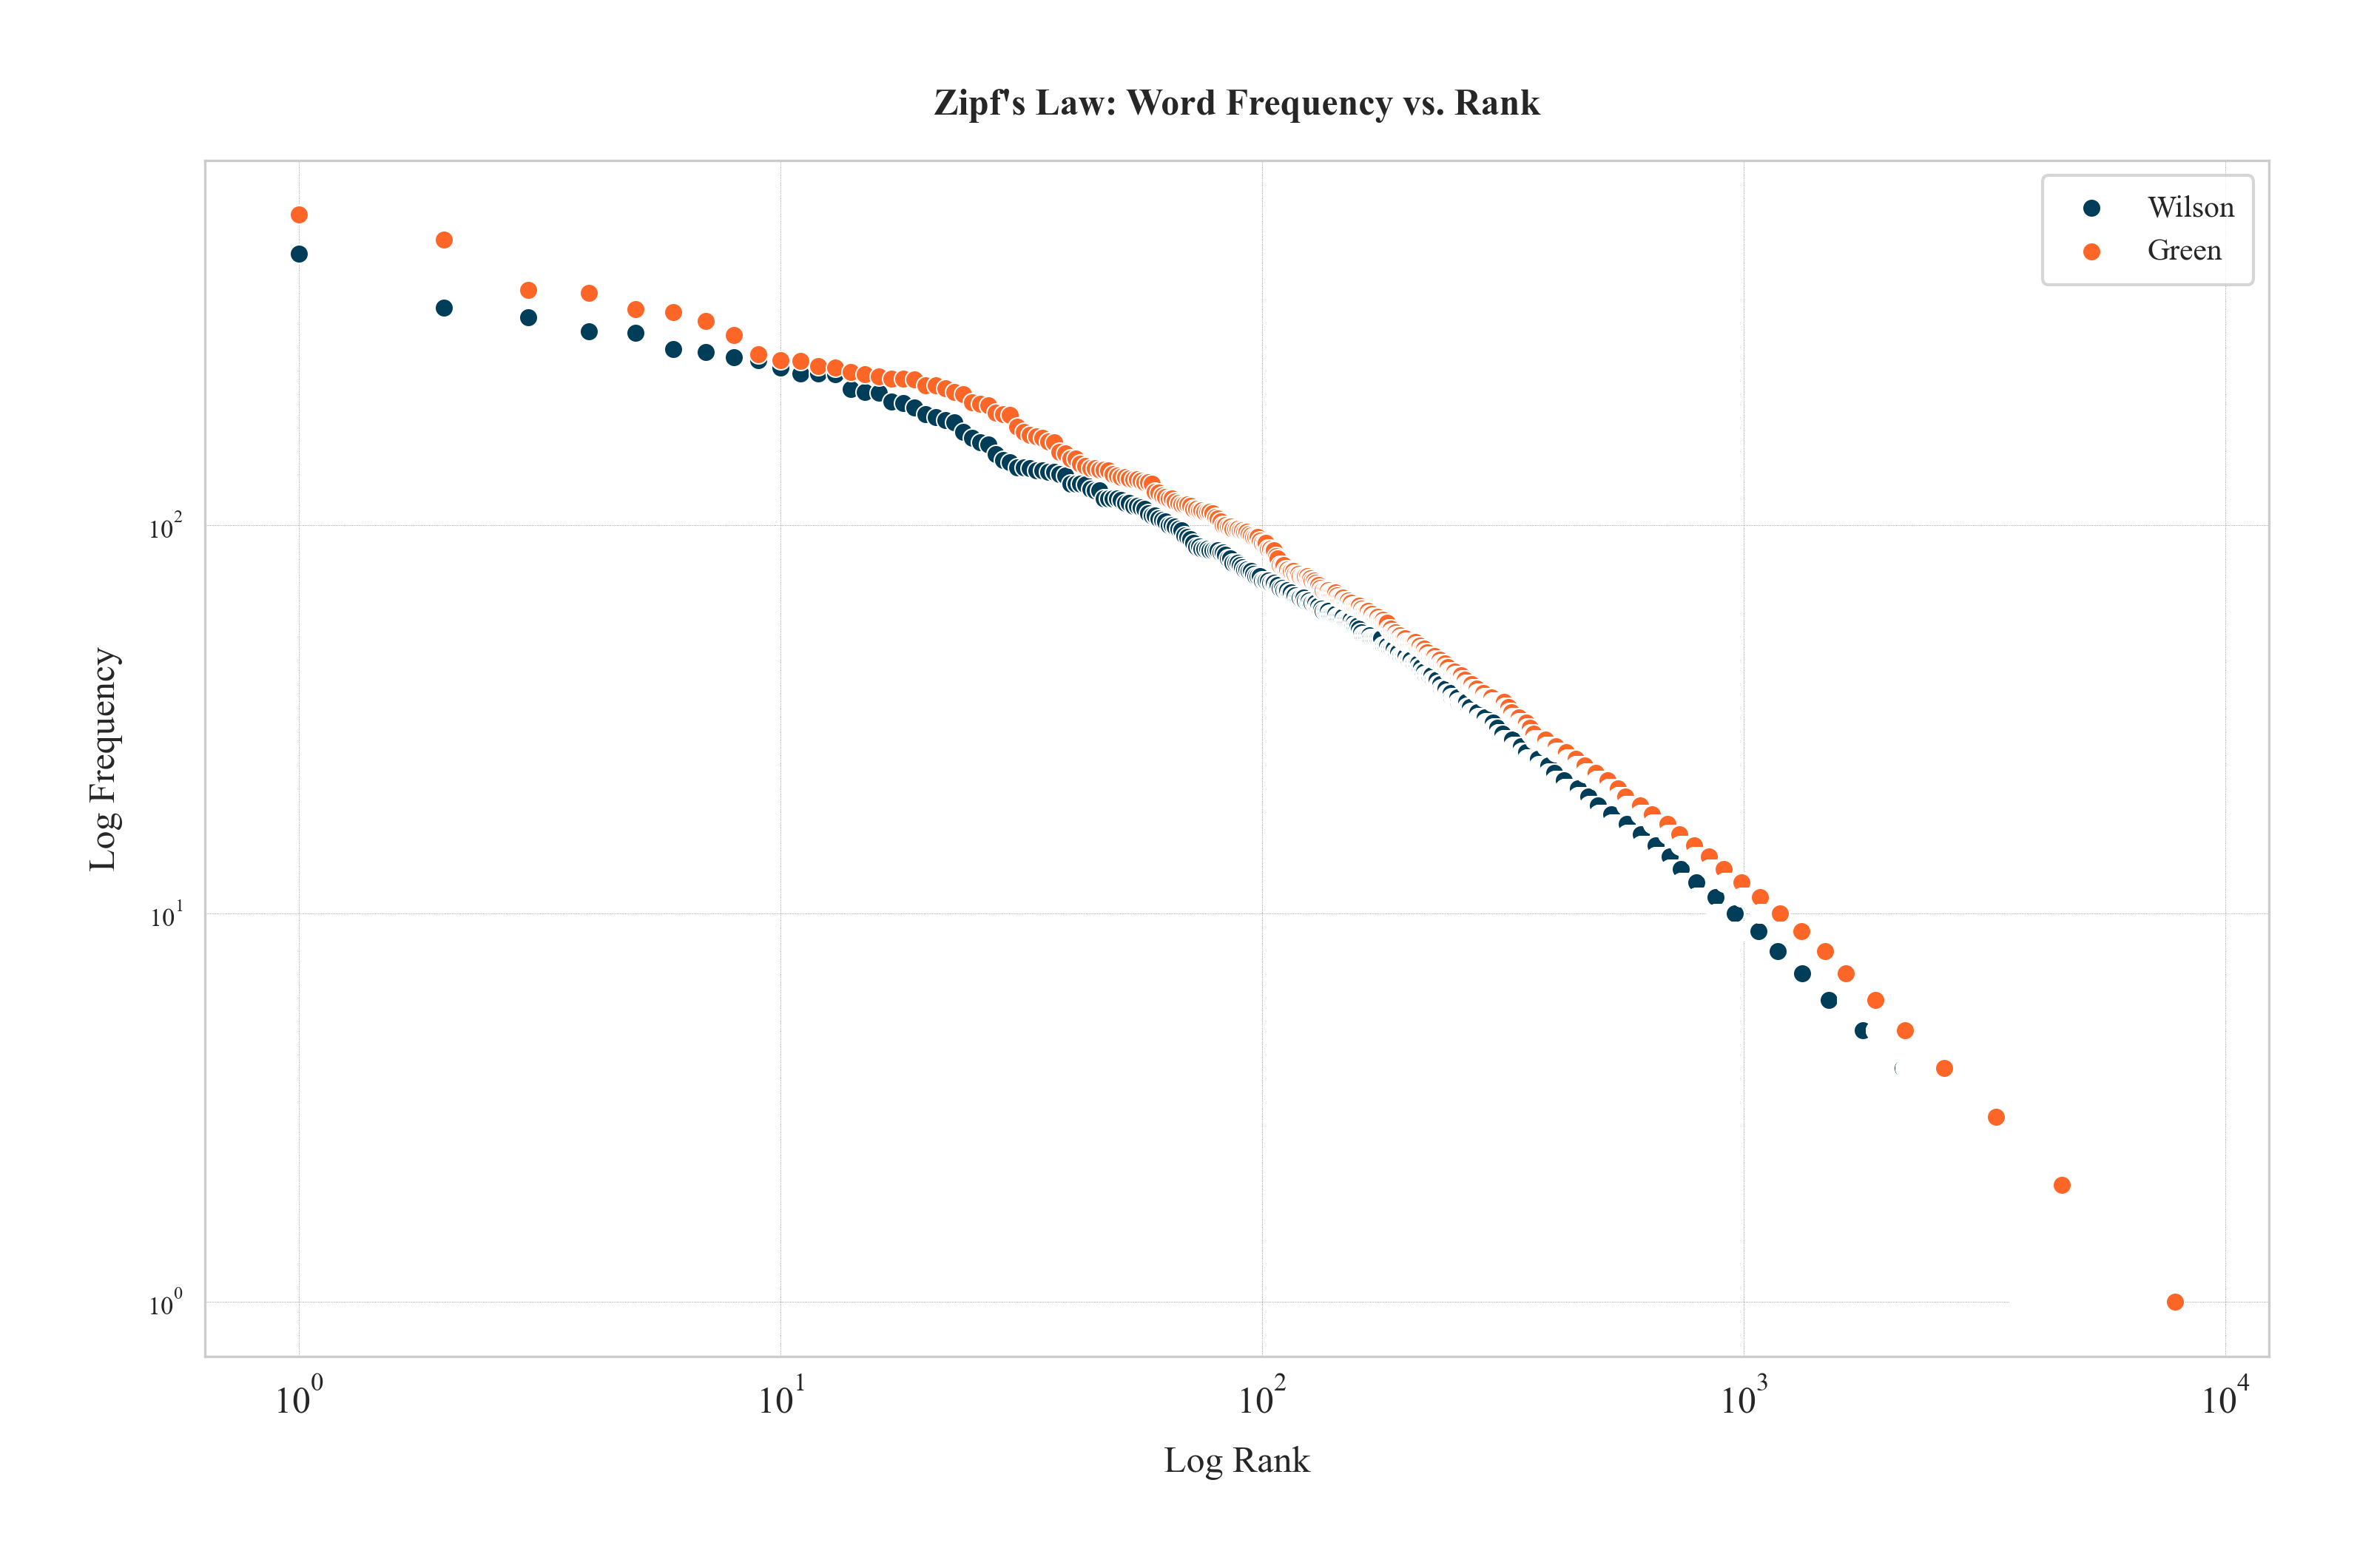

In [14]:
# Plot Wilson and Green's Zipf distribution
sns.scatterplot(x=df_zipf_wilson["rank"], y=df_zipf_wilson["frequency"], label="Wilson")
sns.scatterplot(x=df_zipf_green["rank"], y=df_zipf_green["frequency"], label="Green")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Log Rank")
plt.ylabel("Log Frequency")
plt.title("Zipf's Law: Word Frequency vs. Rank")
plt.legend()
plt.savefig("/Users/debr/English-Homer/MVP_Green-Wilson/MVP_plots/MVP-Zipf_distribution.png")
plt.show()

#### **Statistical Test for Zipf’s Law (Linear Fit)**

In [15]:
import numpy as np
from scipy.stats import linregress

# Perform linear regression in log-log space
log_rank_w = np.log(df_zipf_wilson["rank"])
log_freq_w = np.log(df_zipf_wilson["frequency"])
slope_w, intercept_w, r_value_w, p_value_w, std_err_w = linregress(log_rank_w, log_freq_w)

log_rank_g = np.log(df_zipf_green["rank"])
log_freq_g = np.log(df_zipf_green["frequency"])
slope_g, intercept_g, r_value_g, p_value_g, std_err_g = linregress(log_rank_g, log_freq_g)

# Display results
print(f"Wilson: Slope = {slope_w:.2f}, R² = {r_value_w**2:.3f}, p-value = {p_value_w:.3g}")
print(f"Green: Slope = {slope_g:.2f}, R² = {r_value_g**2:.3f}, p-value = {p_value_g:.3g}")

# Check if slopes are close to -1 (Zipf's Law predicts ~ -1)
if -1.2 < slope_w < -0.8:
    print("Wilson's translation follows Zipf's Law.")
else:
    print("Wilson's translation deviates from Zipf's Law.")

if -1.2 < slope_g < -0.8:
    print("Green's translation follows Zipf's Law.")
else:
    print("Green's translation deviates from Zipf's Law.")

Wilson: Slope = -1.14, R² = 0.959, p-value = 0
Green: Slope = -1.14, R² = 0.960, p-value = 0
Wilson's translation follows Zipf's Law.
Green's translation follows Zipf's Law.


#### **Statistical Test for Differences in Zipf Slopes**

In [16]:
from scipy.stats import ttest_ind

# Compute t-test for the difference in slopes
t_stat, p_value = ttest_ind([slope_w], [slope_g])

# Print results
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.5f}")

# Interpretation
if p_value < 0.05:
    print("The difference in Zipf's Law slopes between Wilson and Green is statistically significant.")
else:
    print("No significant difference in Zipf's Law slopes between Wilson and Green.")

T-statistic: nan, P-value: nan
No significant difference in Zipf's Law slopes between Wilson and Green.


#### Bootstrapped Confidence Intervals

In [17]:
# Function to bootstrap slope estimates
def bootstrap_slopes(log_rank, log_freq, num_samples=1000):
    slopes = []
    for _ in range(num_samples):
        sample_indices = np.random.choice(len(log_rank), len(log_rank), replace=True)
        slope, _, _, _, _ = linregress(log_rank[sample_indices], log_freq[sample_indices])
        slopes.append(slope)
    return np.array(slopes)

# Bootstrap slopes for both translations
bootstrap_slopes_w = bootstrap_slopes(log_rank_w, log_freq_w)
bootstrap_slopes_g = bootstrap_slopes(log_rank_g, log_freq_g)

# Compute 95% confidence intervals
ci_w = np.percentile(bootstrap_slopes_w, [2.5, 97.5])
ci_g = np.percentile(bootstrap_slopes_g, [2.5, 97.5])

print(f"Wilson's slope 95% CI: {ci_w}")
print(f"Green's slope 95% CI: {ci_g}")

# Check if CIs overlap
if (ci_w[0] > ci_g[1]) or (ci_g[0] > ci_w[1]):
    print("Statistically significant difference between the two Zipf slopes.")
else:
    print("No significant difference between the two Zipf slopes.")

Wilson's slope 95% CI: [-1.1552267  -1.11907835]
Green's slope 95% CI: [-1.15682261 -1.12287167]
No significant difference between the two Zipf slopes.


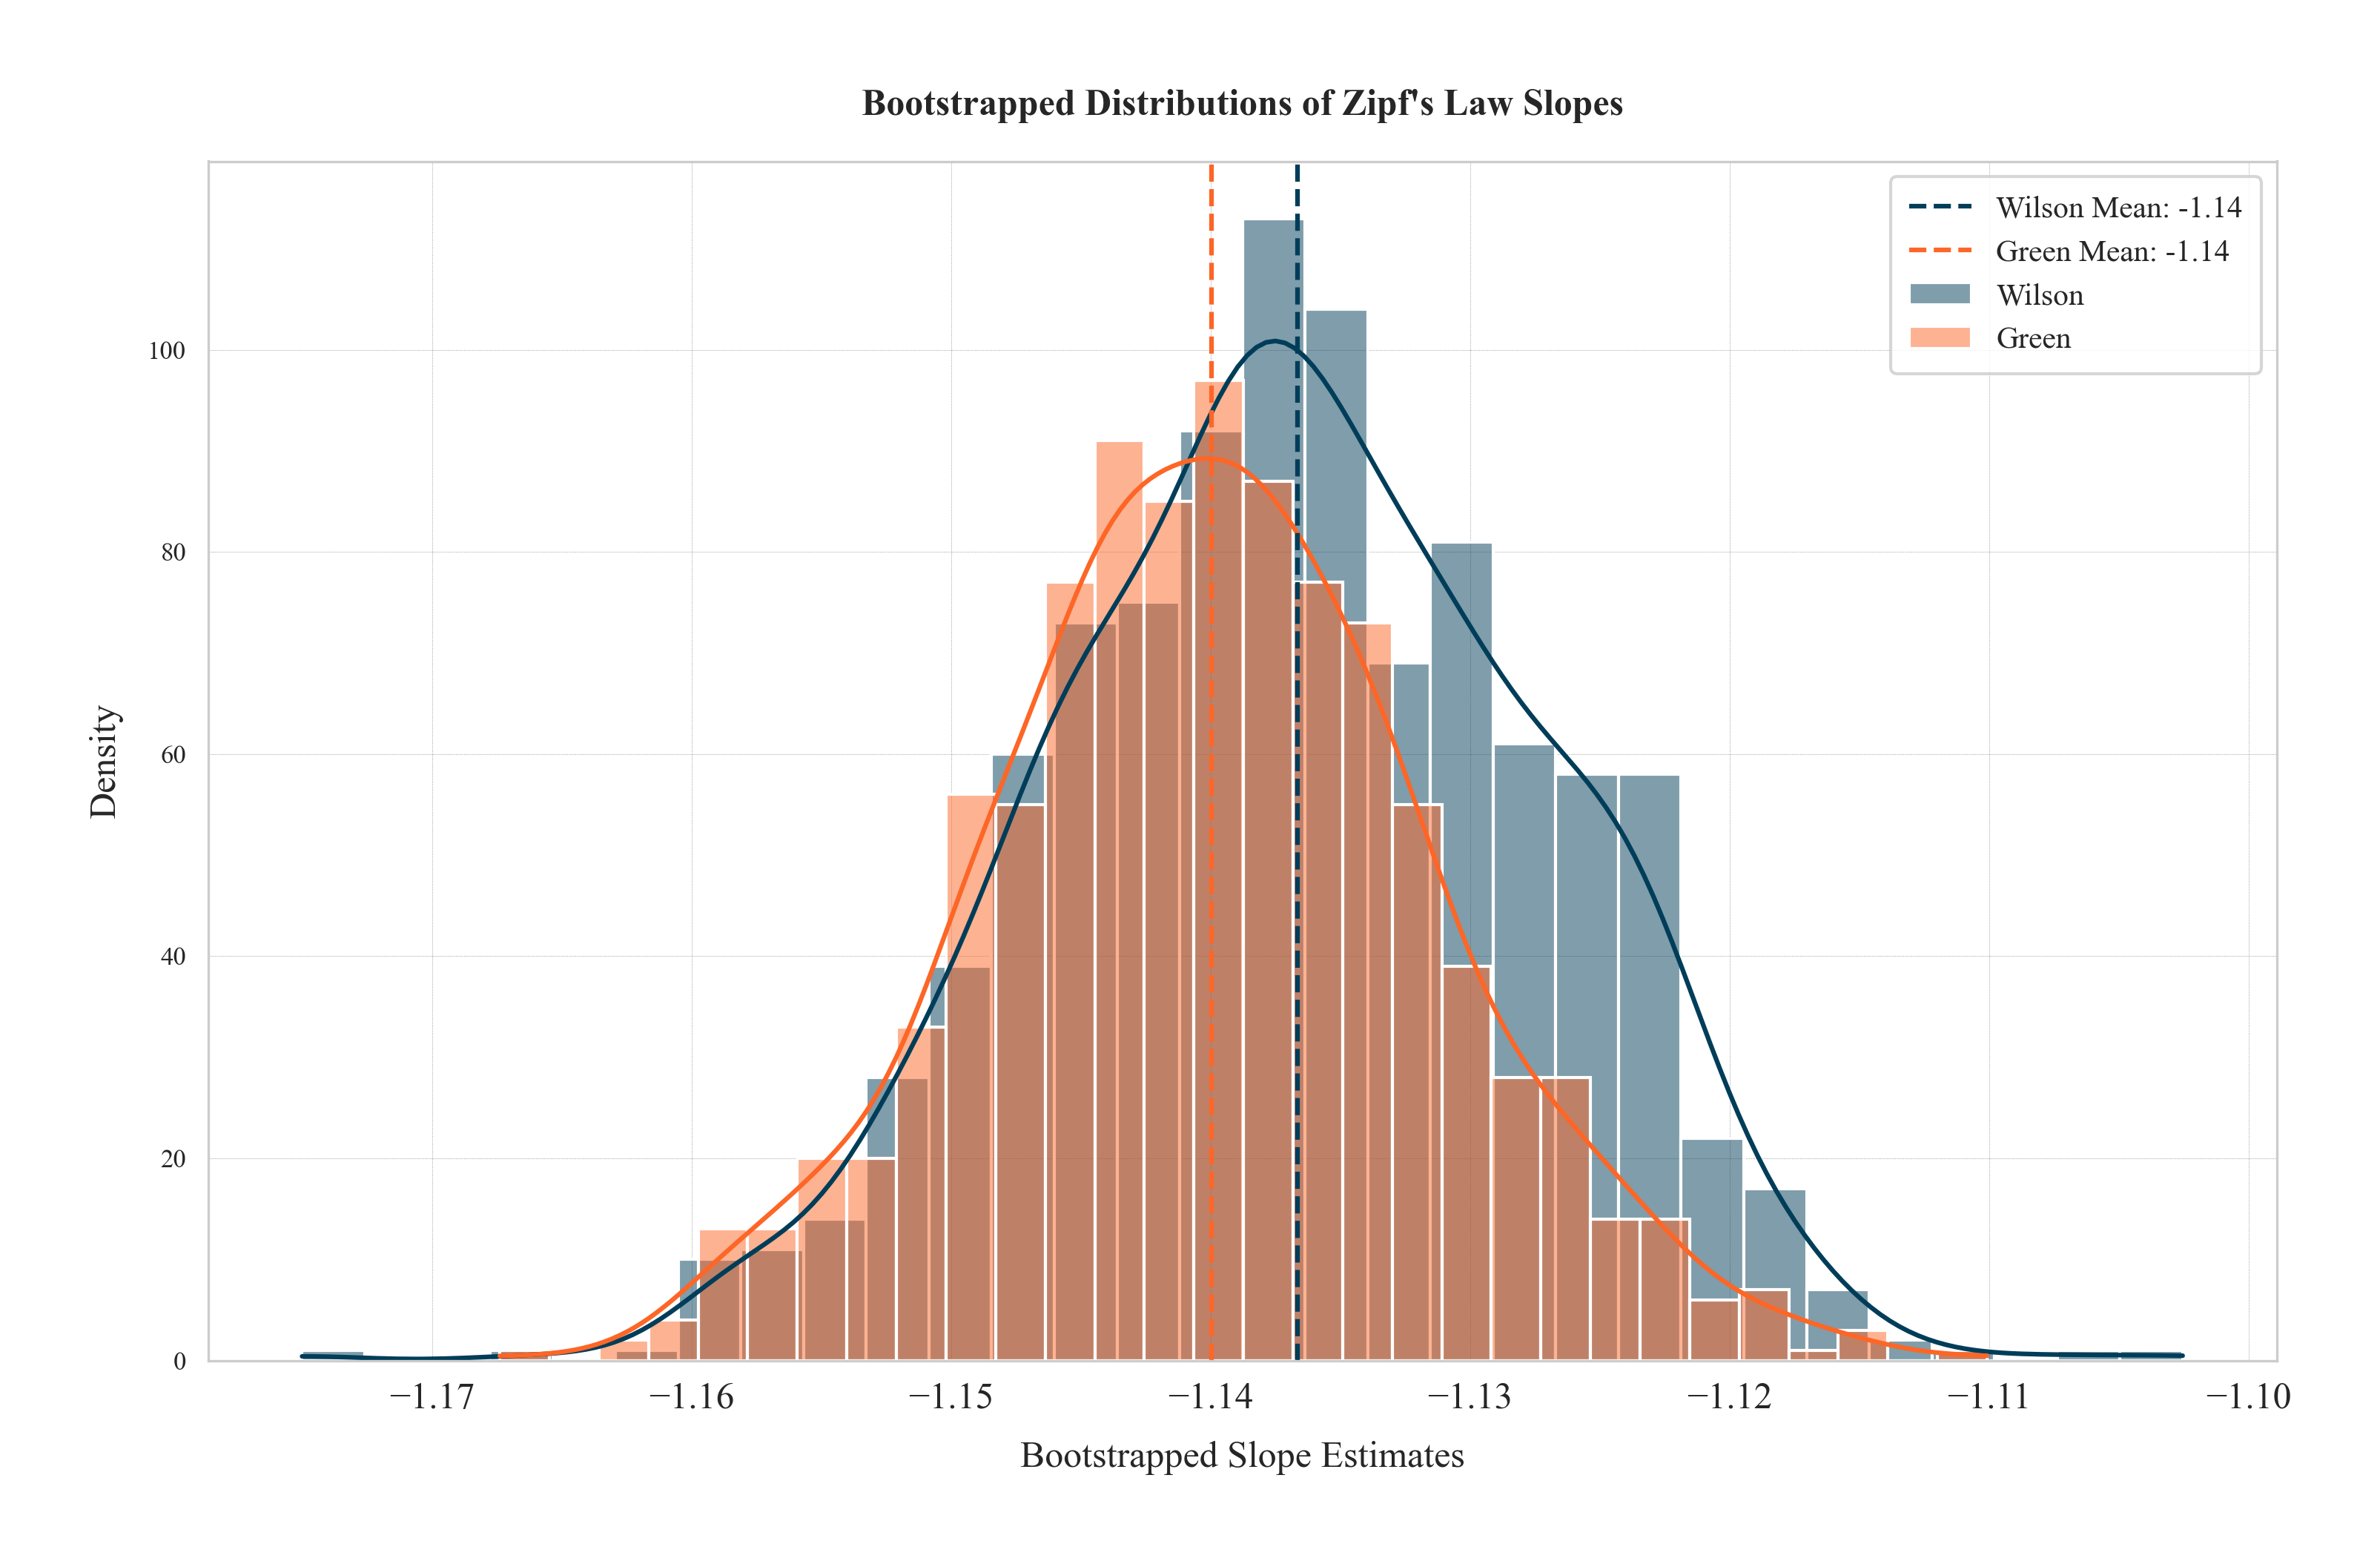

In [18]:
# Plot histograms for bootstrapped slopes
sns.histplot(bootstrap_slopes_w, bins=30, kde=True, label="Wilson", alpha=0.5)
sns.histplot(bootstrap_slopes_g, bins=30, kde=True, label="Green", alpha=0.5)

# Add vertical lines for mean slopes color red

plt.axvline(np.mean(bootstrap_slopes_w), linestyle="--",
                                        color="#003D59",  
                                        label=f"Wilson Mean: {np.mean(bootstrap_slopes_w):.2f}")
plt.axvline(np.mean(bootstrap_slopes_g), linestyle="--", 
                                        color='#FD6626', 
                                        label=f"Green Mean: {np.mean(bootstrap_slopes_g):.2f}")

# Labels and title
plt.xlabel("Bootstrapped Slope Estimates")
plt.ylabel("Density")
plt.title("Bootstrapped Distributions of Zipf's Law Slopes")
plt.legend()
plt.savefig("/Users/debr/English-Homer/MVP_Green-Wilson/MVP_plots/MVP-Zipf_bootstrap.png")
plt.show()

____________________________________________________
## 4️⃣ Experiment 3: **TF-IDF Analysis**  

### **Proving my stpe by step impementation with Wilson's Odyssey**
#### **STEP 1. Term Frequency (TF) Calculation** 

Term Frequency measures how frequently a term appears in a document. It is calculated as:

$$TF(t,d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d}$$

This normalizes term counts by document length, ensuring that longer documents don't get artificially higher weights.

In [19]:
# Step 1: Calculate Term Frequency (TF)
# Wilson's translation
# Function to compute term frequency
def term_freq_by_doc(list_of_tokens):
    token_list = eval(list_of_tokens)  # Ensure tokens are treated as a list
    term_counts = Counter(token_list)  # Count occurrences of each term
    total_terms = len(token_list)  # Total number of terms in the document
    
    # Compute TF: term frequency for each token in the document (normalized by total terms)
    term_freq = {term: count / total_terms for term, count in term_counts.items()}
    
    return term_freq, term_counts

# Apply function to compute TF for each book
df_W["term_freq"], df_W["term_counts"] = zip(*df_W["tokens"].apply(term_freq_by_doc))
df_W.head(2)


,translation,book_id,tokens,term_freq,term_counts
0,Wilson,1_W,"['tell', 'complicated', 'man', 'muse', 'tell',...","{'tell': 0.008097165991902834, 'complicated': ...","{'tell': 14, 'complicated': 1, 'man': 14, 'mus..."
1,Wilson,2_W,"['dangerous', 'journey', 'early', 'dawn', 'bor...","{'dangerous': 0.0005945303210463733, 'journey'...","{'dangerous': 1, 'journey': 8, 'early': 1, 'da..."


### **Inverse Document Frequency (IDF) Calculation**

IDF measures how important a term is by examining how rare it is across all documents:


$$IDF(t) = \log\left(\frac{N}{1 + \text{doc count}}\right)$$

Terms that appear in many documents receive lower IDF scores, reducing their importance in the final TF-IDF score.

In [20]:
# Step 2: Calculate Inverse Document Frequency (IDF)
# Calculate Inverse Document Frequency (IDF)

# Get total number of documents (books)
N = len(df_W)

# Count how many documents contain each term
doc_containing_term = Counter()
for term_counts in df_W["term_freq"]:
    doc_containing_term.update(term_counts.keys())  # Count unique terms in each document

# Compute IDF for each term
idf_scores = {term: np.log(N / (1 + doc_count)) for term, doc_count in doc_containing_term.items()}  # Adding 1 to avoid division by zero

# Add IDF column to df_W
df_W["idf"] = df_W["term_freq"].apply(lambda term_freq: {term: idf_scores[term] for term in term_freq})

# Display results
df_W[["book_id", "idf"]].head(2)

,book_id,idf
0,1_W,"{'tell': -0.040821994520255166, 'complicated':..."
1,2_W,"{'dangerous': 1.2321436812926323, 'journey': 0..."


### **TF-IDF Calculation**

TF-IDF combines Term Frequency and Inverse Document Frequency to weight terms based on both their importance in a specific document and their distinctiveness across the corpus:

$$TF\text{-}IDF(t,d) = TF(t,d) \times IDF(t)$$

Terms with high TF-IDF scores appear frequently in a specific document but rarely in other documents, making them likely more important for that document's content.

In [21]:
# Step 3: Calculate TF-IDF
# Compute TF-IDF by multiplying TF and IDF for each term in each document
df_W["tf_idf"] = df_W.apply(lambda row: {term: row["term_freq"][term] * row["idf"][term] for term in row["term_freq"]}, axis=1)

# Display results
df_W[["book_id", "tf_idf"]].head(2)

,book_id,tf_idf
0,1_W,"{'tell': -0.00033054246575105396, 'complicated..."
1,2_W,"{'dangerous': 0.000732546778414169, 'journey':..."


### **E2E TF-IDF Function & Visualization**
#### **Green's Odyssey** 
**The algorith**

In [22]:
import pandas as pd
import numpy as np
from collections import Counter

def calculate_tfidf(df):
    """
    Calculate TF-IDF scores for a DataFrame with book_id and tokens columns.
    
    Parameters:
    -----------
    df : pandas DataFrame
        A DataFrame with 'book_id' and 'tokens' columns. 
        The 'tokens' column should contain lists of tokens (as strings or actual lists).
    
    Returns:
    --------
    pandas DataFrame
        The original DataFrame with additional columns:
        - term_freq: Dictionary of term frequencies for each token
        - term_counts: Dictionary of raw counts for each token
        - idf: Dictionary of IDF scores for each token
        - tf_idf: Dictionary of TF-IDF scores for each token
    """
    # Create a copy of the DataFrame to avoid modifying the original
    result_df = df.copy()
    
    # Function to compute term frequency and term counts
    def term_freq_by_doc(list_of_tokens):
        # Handle both string representation of list and actual list
        if isinstance(list_of_tokens, str):
            token_list = eval(list_of_tokens)  # Convert string representation to list
        else:
            token_list = list_of_tokens  # Use as is if already a list
        
        # Count occurrences of each term
        term_counts = Counter(token_list)
        
        # Total number of terms in the document
        total_terms = len(token_list)
        
        # Compute TF: term frequency for each token
        term_freq = {term: count / total_terms for term, count in term_counts.items()}
        
        return term_freq, term_counts
    
    # Apply function to compute TF for each book
    result_df["term_freq"], result_df["term_counts"] = zip(*result_df["tokens"].apply(term_freq_by_doc))
    
    # Get total number of documents (books)
    N = len(result_df)
    
    # Count how many documents contain each term
    doc_containing_term = Counter()
    for term_counts in result_df["term_freq"]:
        doc_containing_term.update(term_counts.keys())  # Count unique terms in each document
    
    # Compute IDF for each term
    idf_scores = {term: np.log(N / (1 + doc_count)) for term, doc_count in doc_containing_term.items()}  # Adding 1 to avoid division by zero
    
    # Add IDF column to df
    result_df["idf"] = result_df["term_freq"].apply(lambda term_freq: {term: idf_scores[term] for term in term_freq})
    
    # Compute TF-IDF by multiplying TF and IDF for each term in each document
    result_df["tf_idf"] = result_df.apply(lambda row: {term: row["term_freq"][term] * row["idf"][term] for term in row["term_freq"]}, axis=1)
    
    return result_df

df_tfidf_G = calculate_tfidf(df_G)
df_tfidf_G[["book_id","tf_idf"]].head(2)

,book_id,tf_idf
0,1_G,"{'man': -0.00035908235920594823, 'muse': 0.000..."
1,2_G,"{'dawn': 4.09818145583013e-05, 'appeared': 8.7..."


**The visualization**

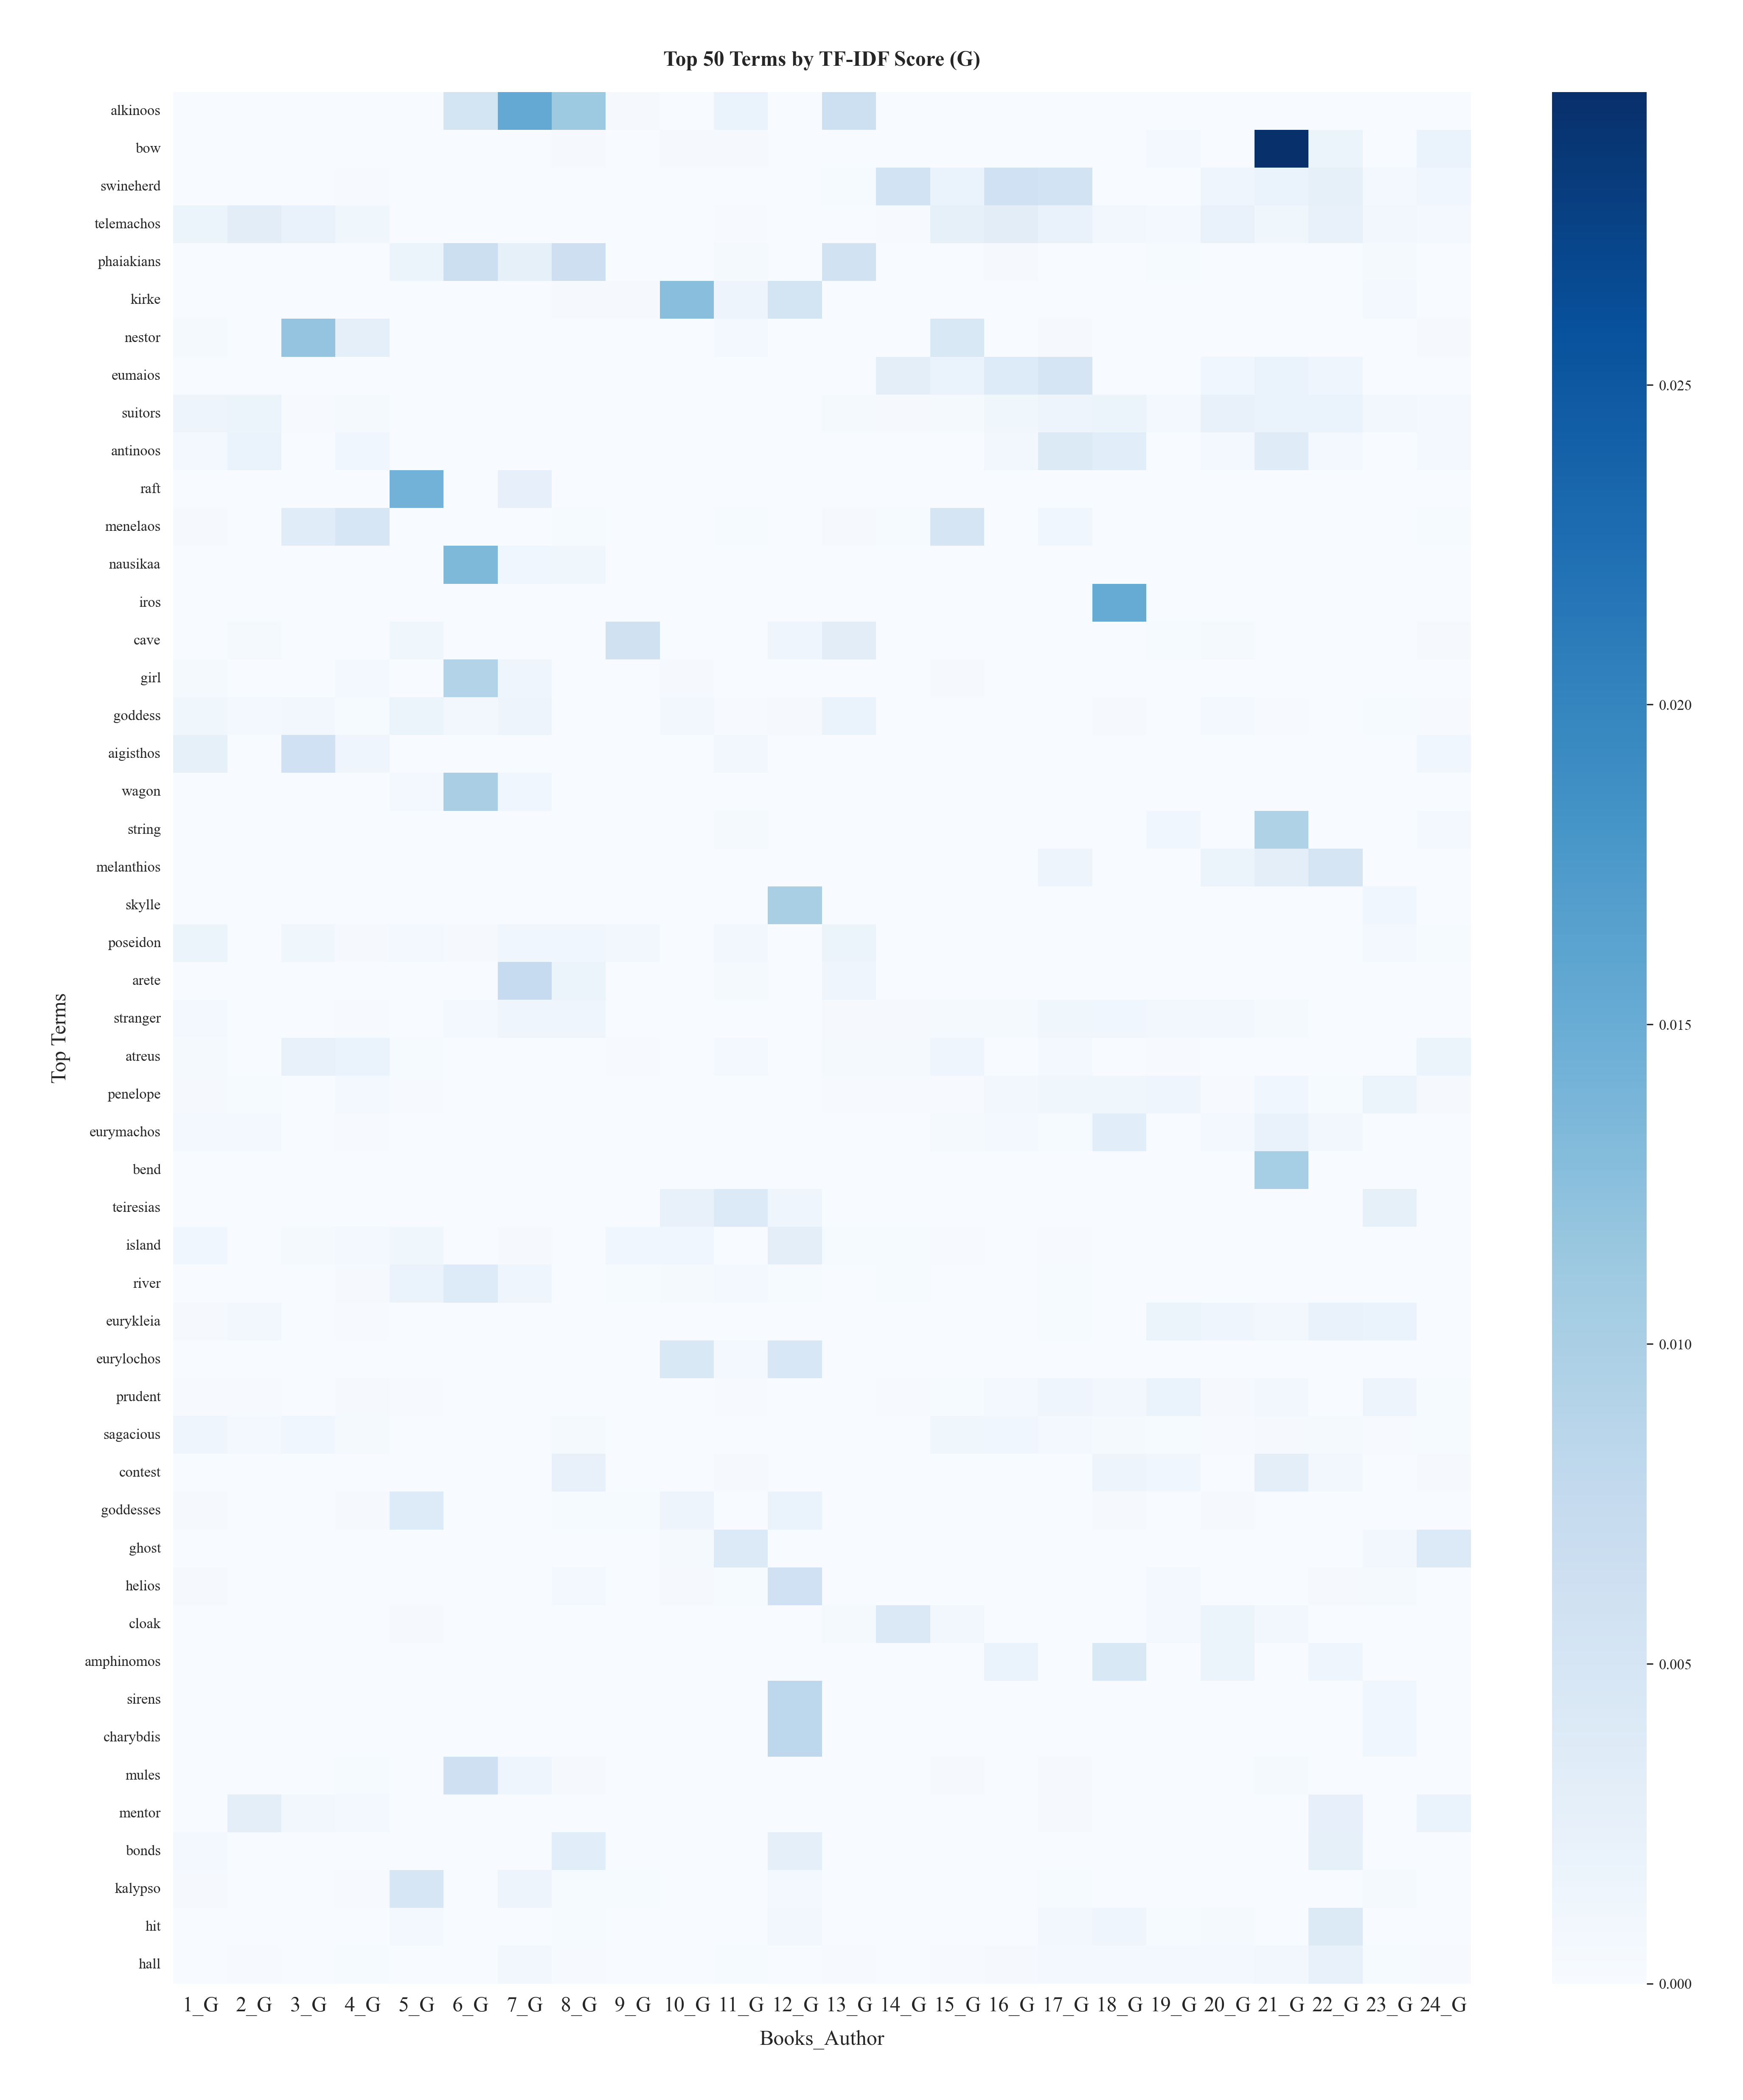

In [23]:
# Top terms for each book and heatmap plot

def extract_top_terms(df, n=50):
    """
    Extract the top N most important terms from the tf_idf column
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with 'book_id' and 'tf_idf' columns
    n : int
        Number of top terms to extract (default: 50)
    
    Returns:
    --------
    tuple
        (top_terms_per_book, top_terms_overall)
        - top_terms_per_book: DataFrame with top terms for each book
        - top_terms_overall: DataFrame with top terms across all books
    """
    # Extract top terms per book
    top_terms_per_book = {}
    
    for _, row in df.iterrows():
        book_id = row['book_id']
        tf_idf_dict = row['tf_idf']
        
        # Sort terms by tf-idf score (descending) and take top N
        sorted_terms = sorted(tf_idf_dict.items(), key=lambda x: x[1], reverse=True)[:n]
        top_terms_per_book[book_id] = {term: score for term, score in sorted_terms}
    
    # Convert to DataFrame for easier analysis
    top_terms_df = pd.DataFrame.from_dict(top_terms_per_book, orient='index')
    
    # Extract top terms overall
    all_terms = {}
    for tf_idf_dict in df['tf_idf']:
        for term, score in tf_idf_dict.items():
            if term in all_terms:
                all_terms[term] += score
            else:
                all_terms[term] = score
    
    # Sort terms by total tf-idf score (descending) and take top N
    top_terms_overall = sorted(all_terms.items(), key=lambda x: x[1], reverse=True)[:n]
    
    # Convert to DataFrame
    top_terms_overall_df = pd.DataFrame(top_terms_overall, columns=['term', 'total_score'])
    
    return top_terms_df, top_terms_overall_df

def create_tfidf_heatmap(df, top_n=50):
    """
    Create a heatmap of the top N terms across all books
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with 'book_id' and 'tf_idf' columns
    top_n : int
        Number of top terms to include in the heatmap (default: 50)
    """
    # Extract top terms overall
    _, top_terms = extract_top_terms(df, n=top_n)
    top_terms_list = top_terms['term'].tolist()
    
    # Create a matrix of book_id x top_terms
    heatmap_data = []
    book_ids = []
    
    for _, row in df.iterrows():
        book_id = row['book_id']
        book_ids.append(book_id)
        
        tf_idf_dict = row['tf_idf']
        
        # Extract scores for top terms
        scores = [tf_idf_dict.get(term, 0) for term in top_terms_list]
        heatmap_data.append(scores)
    
    # Convert to numpy array
    heatmap_array = np.array(heatmap_data).T
    
    # Create heatmap
    plt.figure(figsize=(14, 16))
    sns.heatmap(heatmap_array, cmap='Blues', xticklabels=book_ids, yticklabels=top_terms_list)
    plt.title(f'Top {top_n} Terms by TF-IDF Score ({df["book_id"].iloc[0][2:]})')
    plt.xlabel('Books_Author')
    plt.ylabel('Top Terms')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"/Users/debr/English-Homer/MVP_Green-Wilson/MVP_plots/MVP-TFIDF_heatmap({df['book_id'].iloc[0][2:]}).png")
    plt.show()
    
    return heatmap_array

top_terms_per_book_G, top_terms_overall_G = extract_top_terms(df_tfidf_G)
heatmap_array = create_tfidf_heatmap(df_tfidf_G)

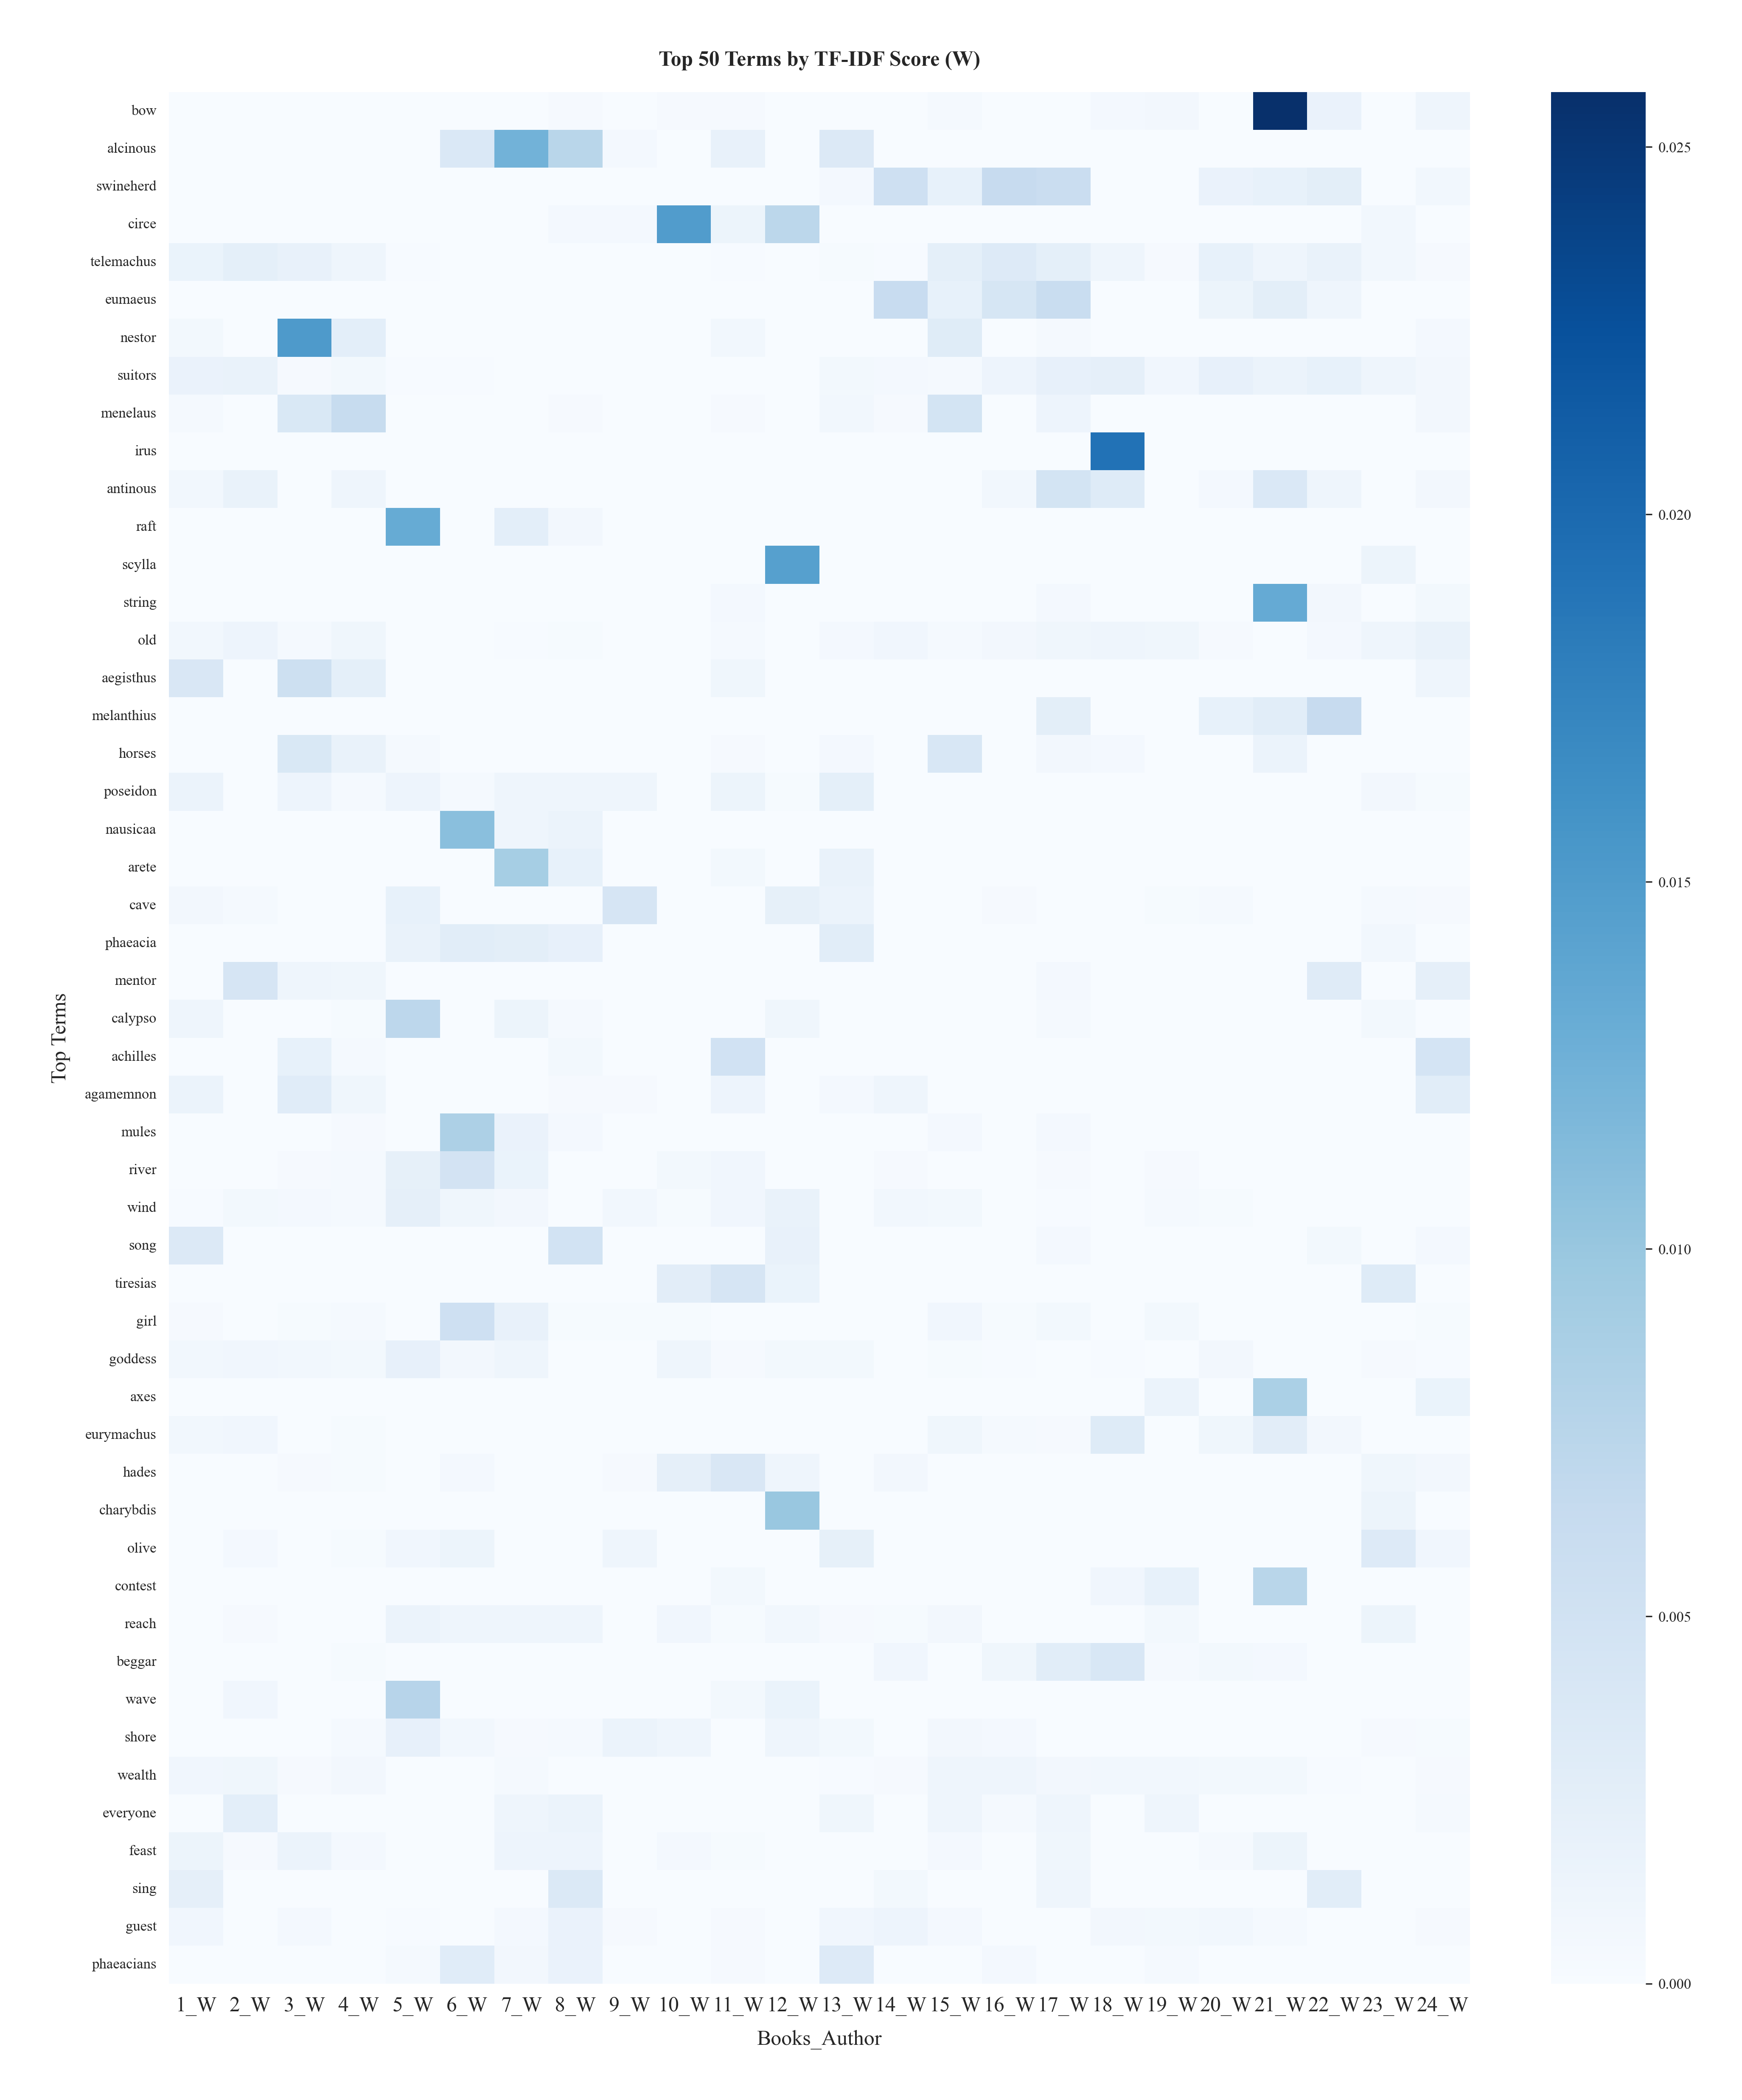

In [24]:
top_terms_per_book_W, top_terms_overall_W = extract_top_terms(df_W)
heatmap_array = create_tfidf_heatmap(df_W)

Wilson shows similar results to Green, using the step by step approach. Wilson's Odyssey (df) will be processed by the **e2e function**, so both translations have the same processing. 

In [25]:
df_tfidf_W = calculate_tfidf(df_W)

In [26]:
# Getting and then comparing W & G's
# 30 top terms 
tt_W = top_terms_overall_W['term'][:30]
tt_G = top_terms_overall_G['term'][:30]
# New df with the top terms from both for comparison
top_terms_overall = pd.DataFrame({'Wilson': tt_W, 'Green': tt_G})
top_terms_overall.T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
Wilson,bow,alcinous,swineherd,circe,telemachus,eumaeus,nestor,suitors,menelaus,irus,...,arete,cave,phaeacia,mentor,calypso,achilles,agamemnon,mules,river,wind
Green,alkinoos,bow,swineherd,telemachos,phaiakians,kirke,nestor,eumaios,suitors,antinoos,...,melanthios,skylle,poseidon,arete,stranger,atreus,penelope,eurymachos,bend,teiresias


- 📊 **Parametric Hypothesis Testing:** Assessing significant variations.  
Checking at the word by word comparison the similarities in choice of words is apparent. Thus the next step will be testing, but before chosing the test we need to check if the data distribution is normal.

In [27]:
# Calculate the sum of the tf-idf scores for each translation
itidf_W = df_tfidf_W["tf_idf"].apply(lambda x: list(x.values())).sum()
itidf_G = df_tfidf_G["tf_idf"].apply(lambda x: list(x.values())).sum()

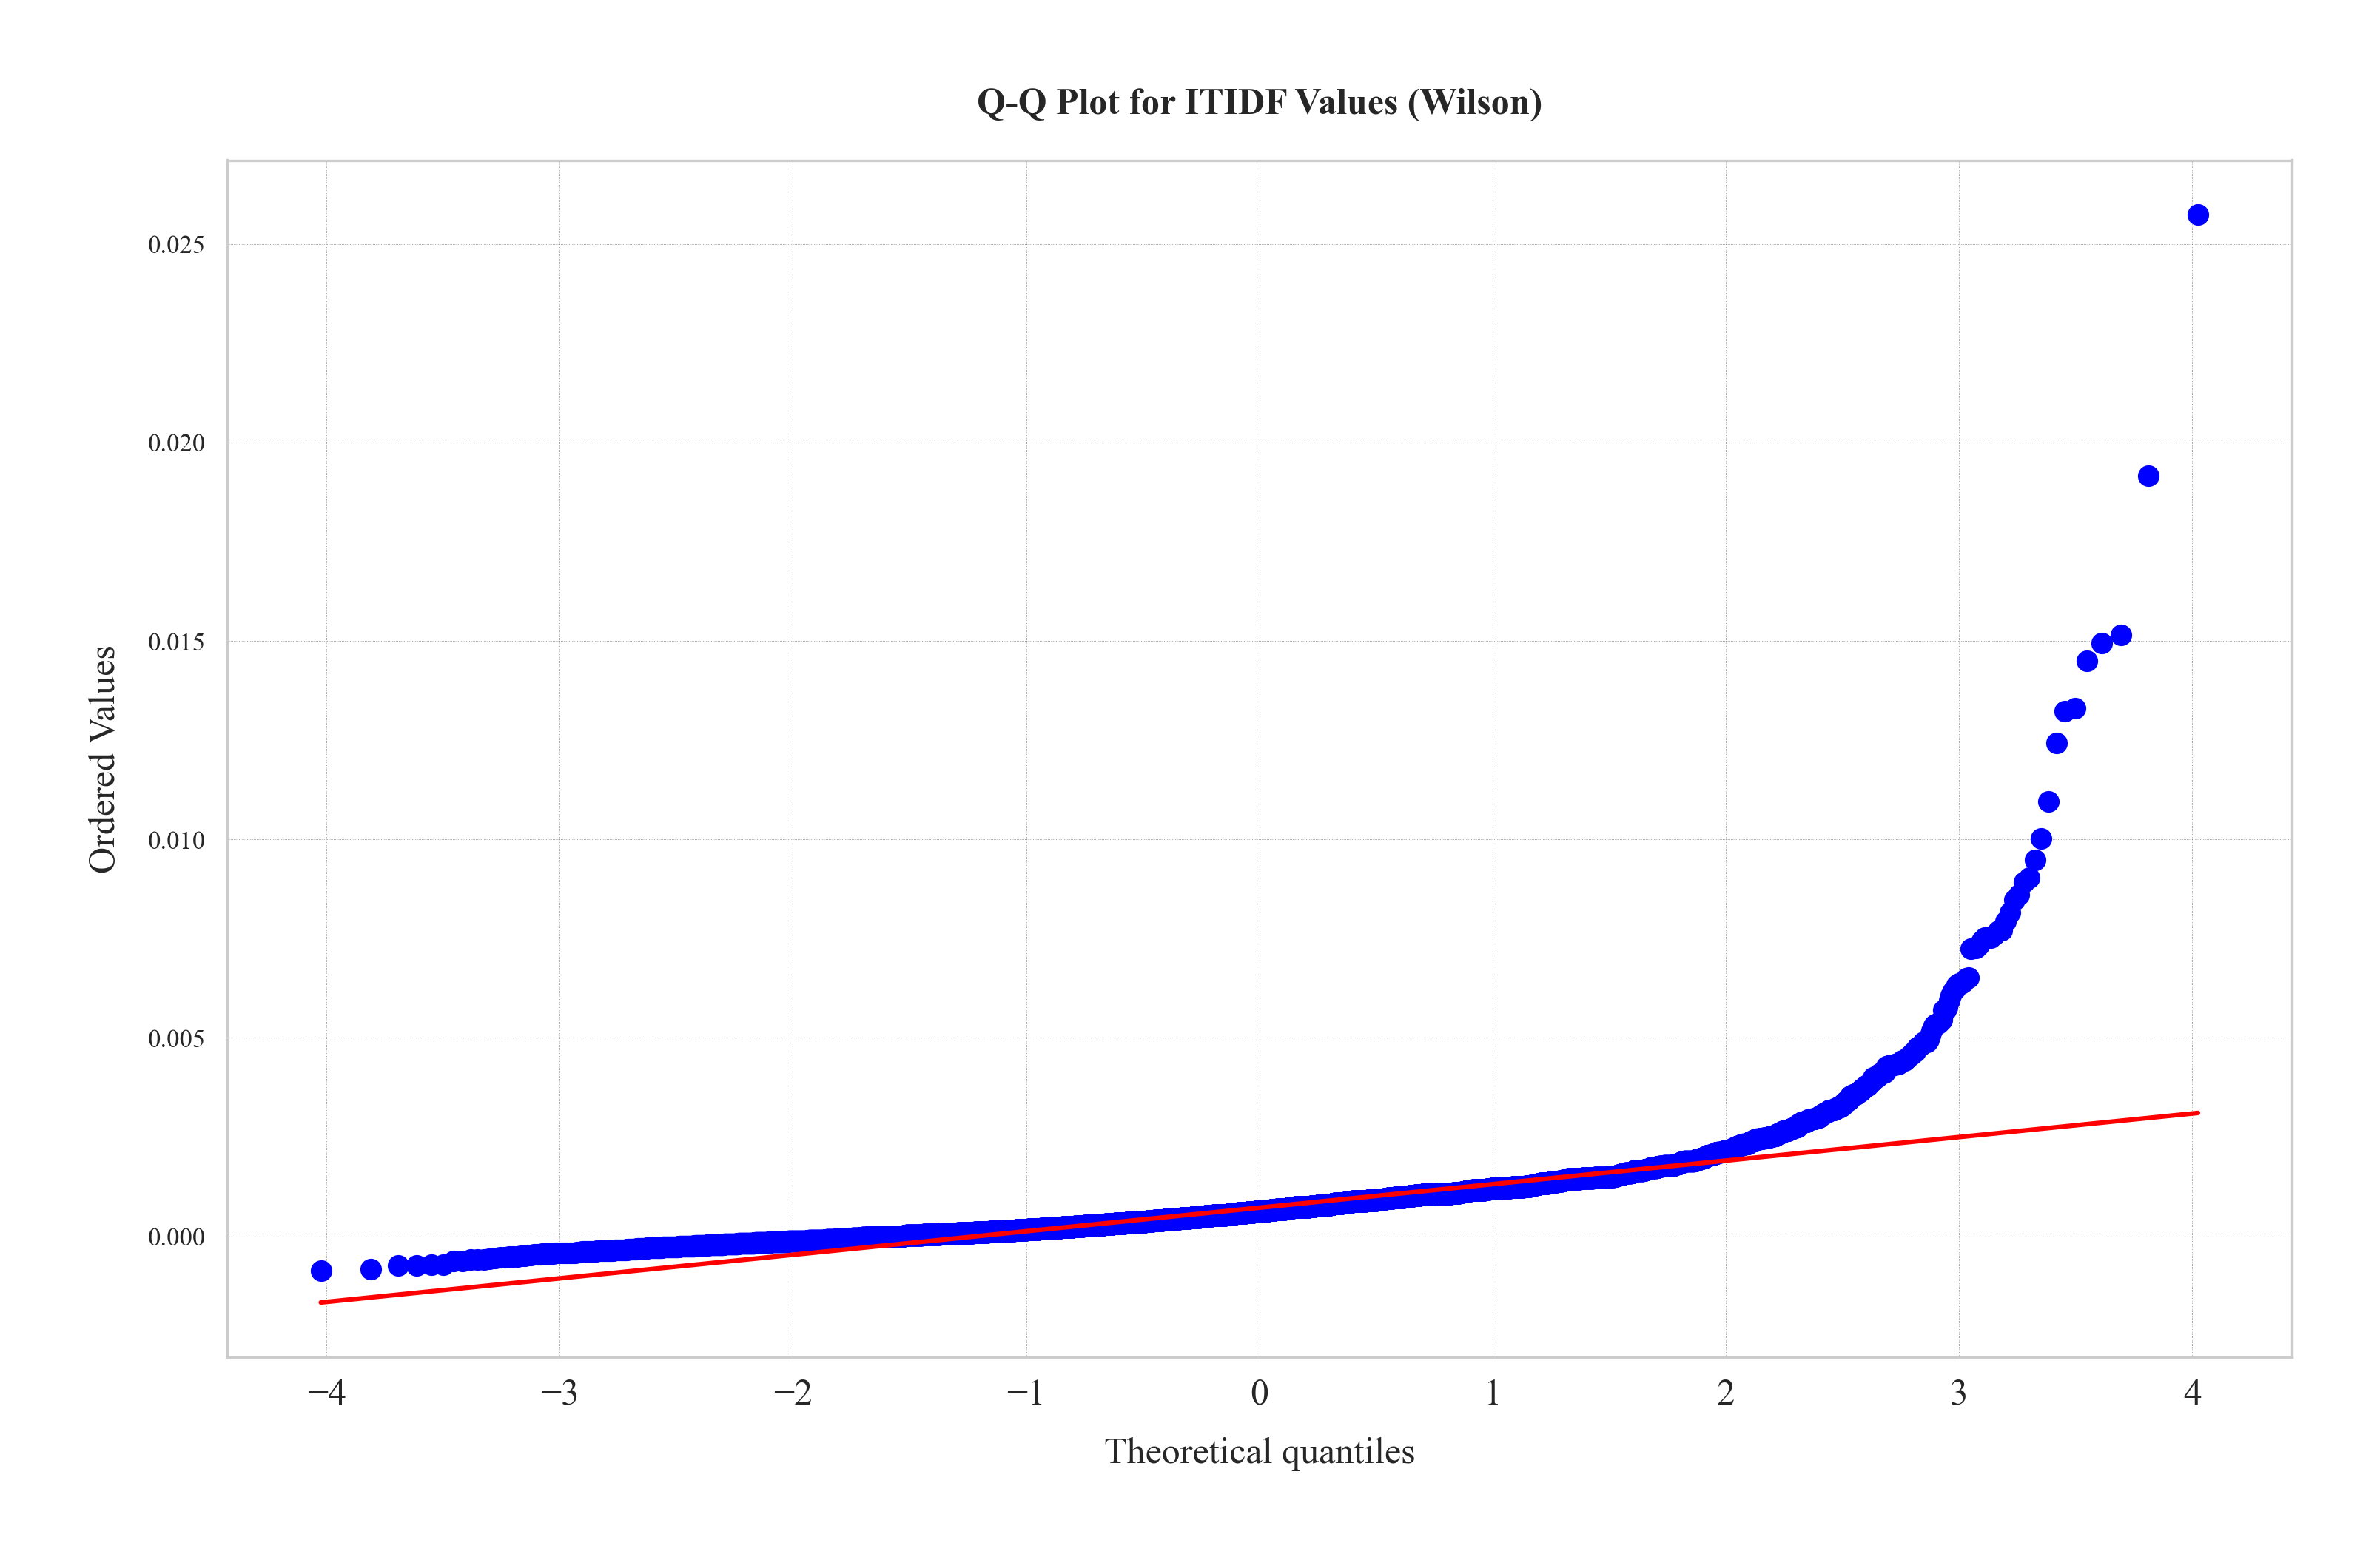

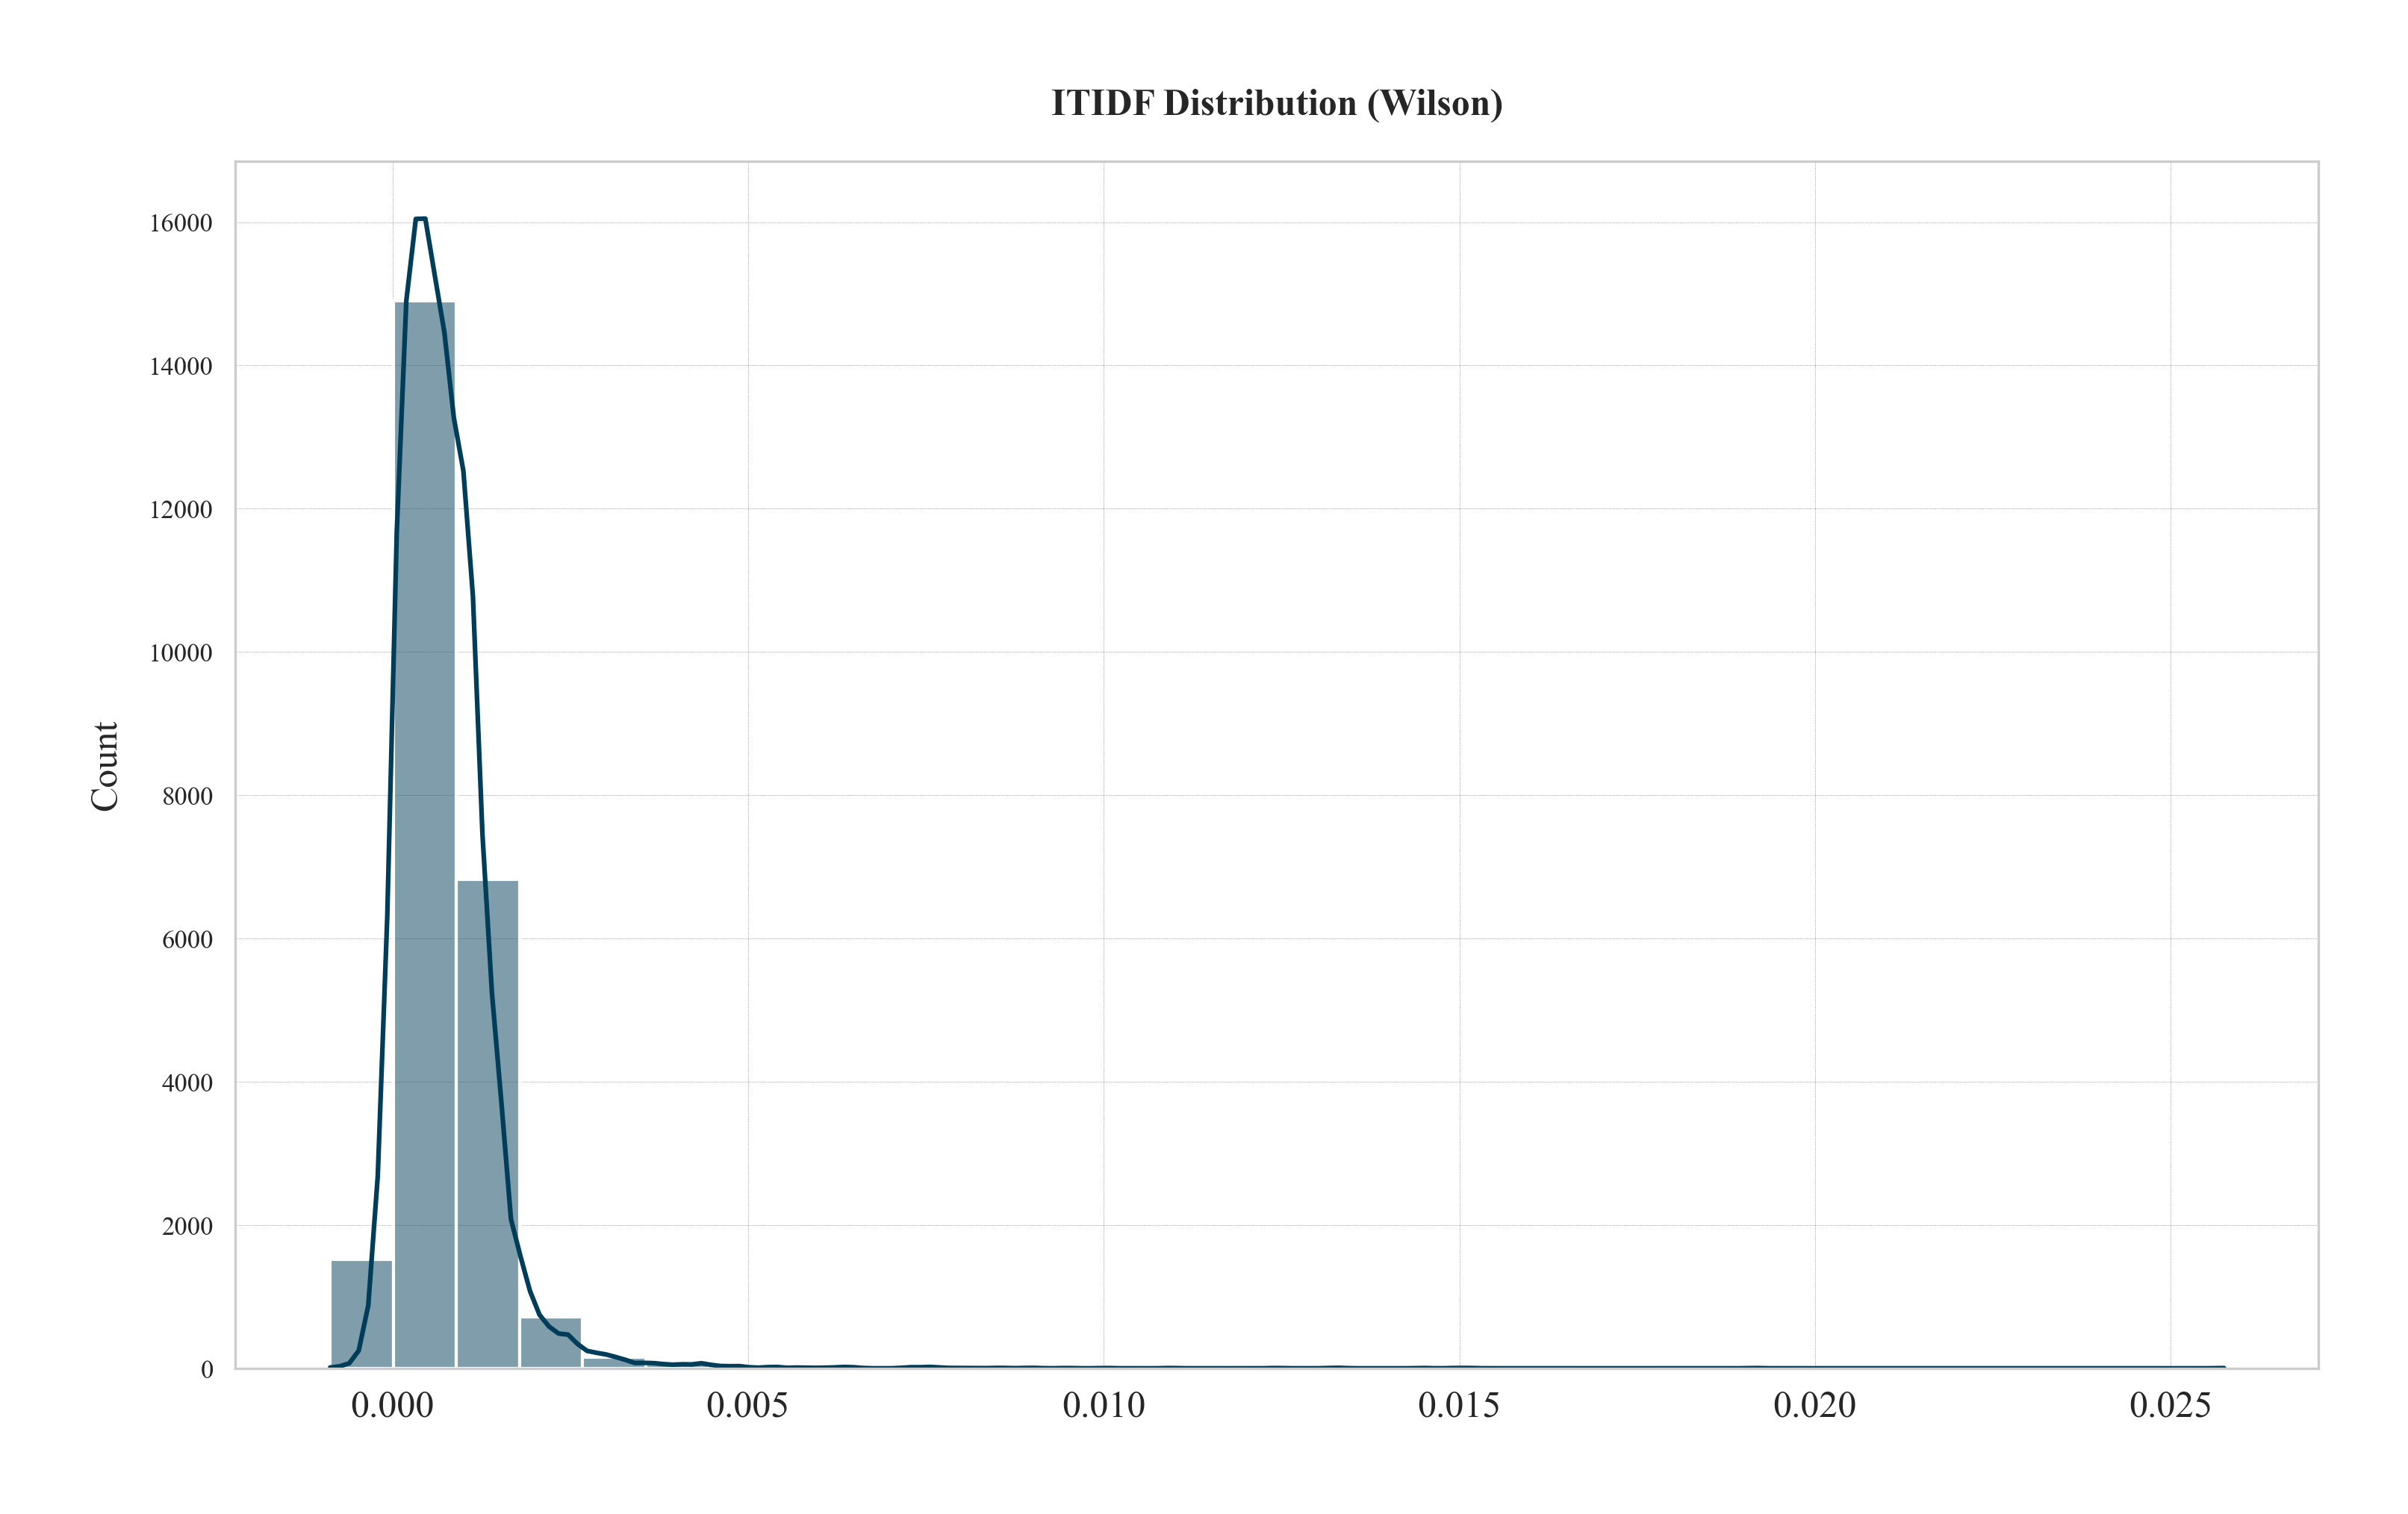

In [28]:
import scipy.stats as stats
# Q-Q plot for ITIDF values
def plot_qq(itidf, translator="Wilson"):
    """
    Create a Q-Q plot for the ITIDF values.
    
    Parameters:
    -----------
    itidf : list
        List of ITIDF values to plot
    """
    # Generate a Q-Q plot
    stats.probplot(itidf_W, dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for ITIDF Values ({translator})")
    plt.savefig(f"/Users/debr/English-Homer/MVP_Green-Wilson/MVP_plots/Q-Q_Plot_{translator}.png")
    plt.show()

def plot_itidf_distribution(itidf, translator="Wilson"):
    """
    Plot the distribution of ITIDF values.
    
    Parameters:
    -----------
    itidf : list
        List of ITIDF values to plot
    """
    # Create a histogram of the ITIDF values
    sns.histplot(itidf, bins=30, kde=True)  # KDE adds a smoothed curve
    plt.title(f"ITIDF Distribution ({translator})")
    plt.savefig(f"/Users/debr/English-Homer/MVP_Green-Wilson/MVP_plots/ITIDF_Distribution_{translator}.png")
    plt.show()

# Plot Q-Q plot and distribution for ITIDF values for Wilson
plot_qq(itidf_W, "Wilson")
plot_itidf_distribution(itidf_W, "Wilson")

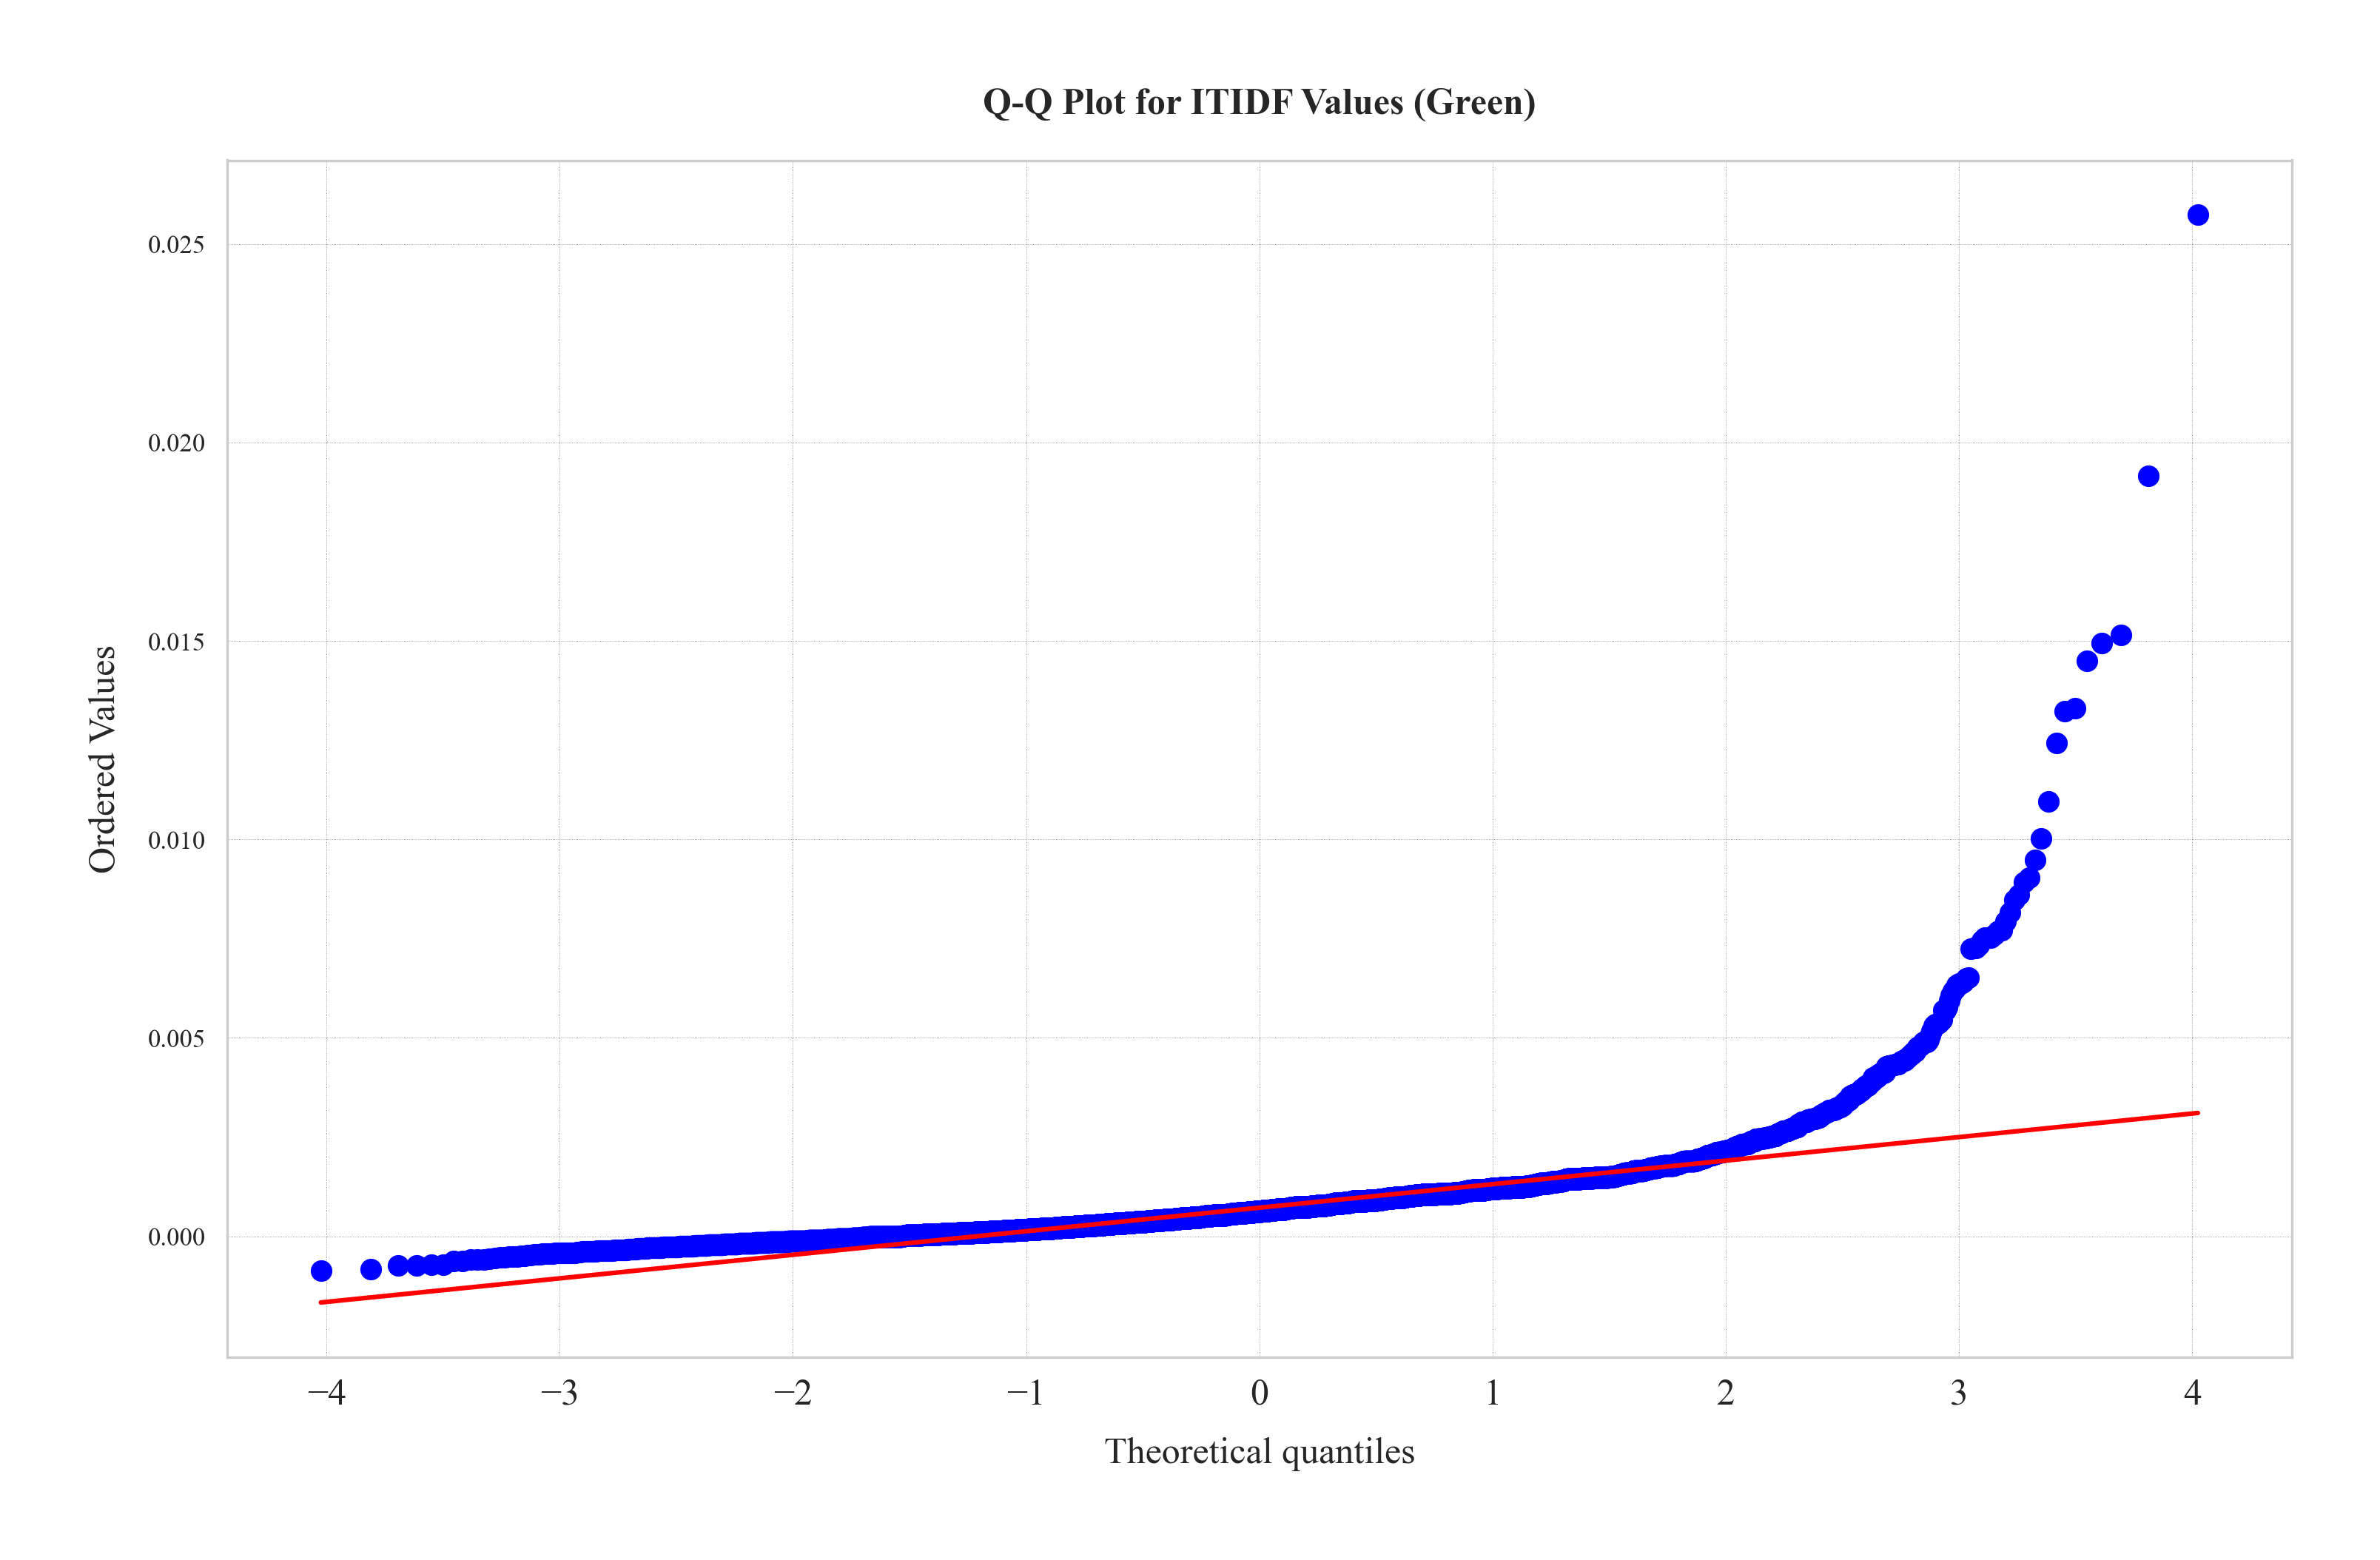

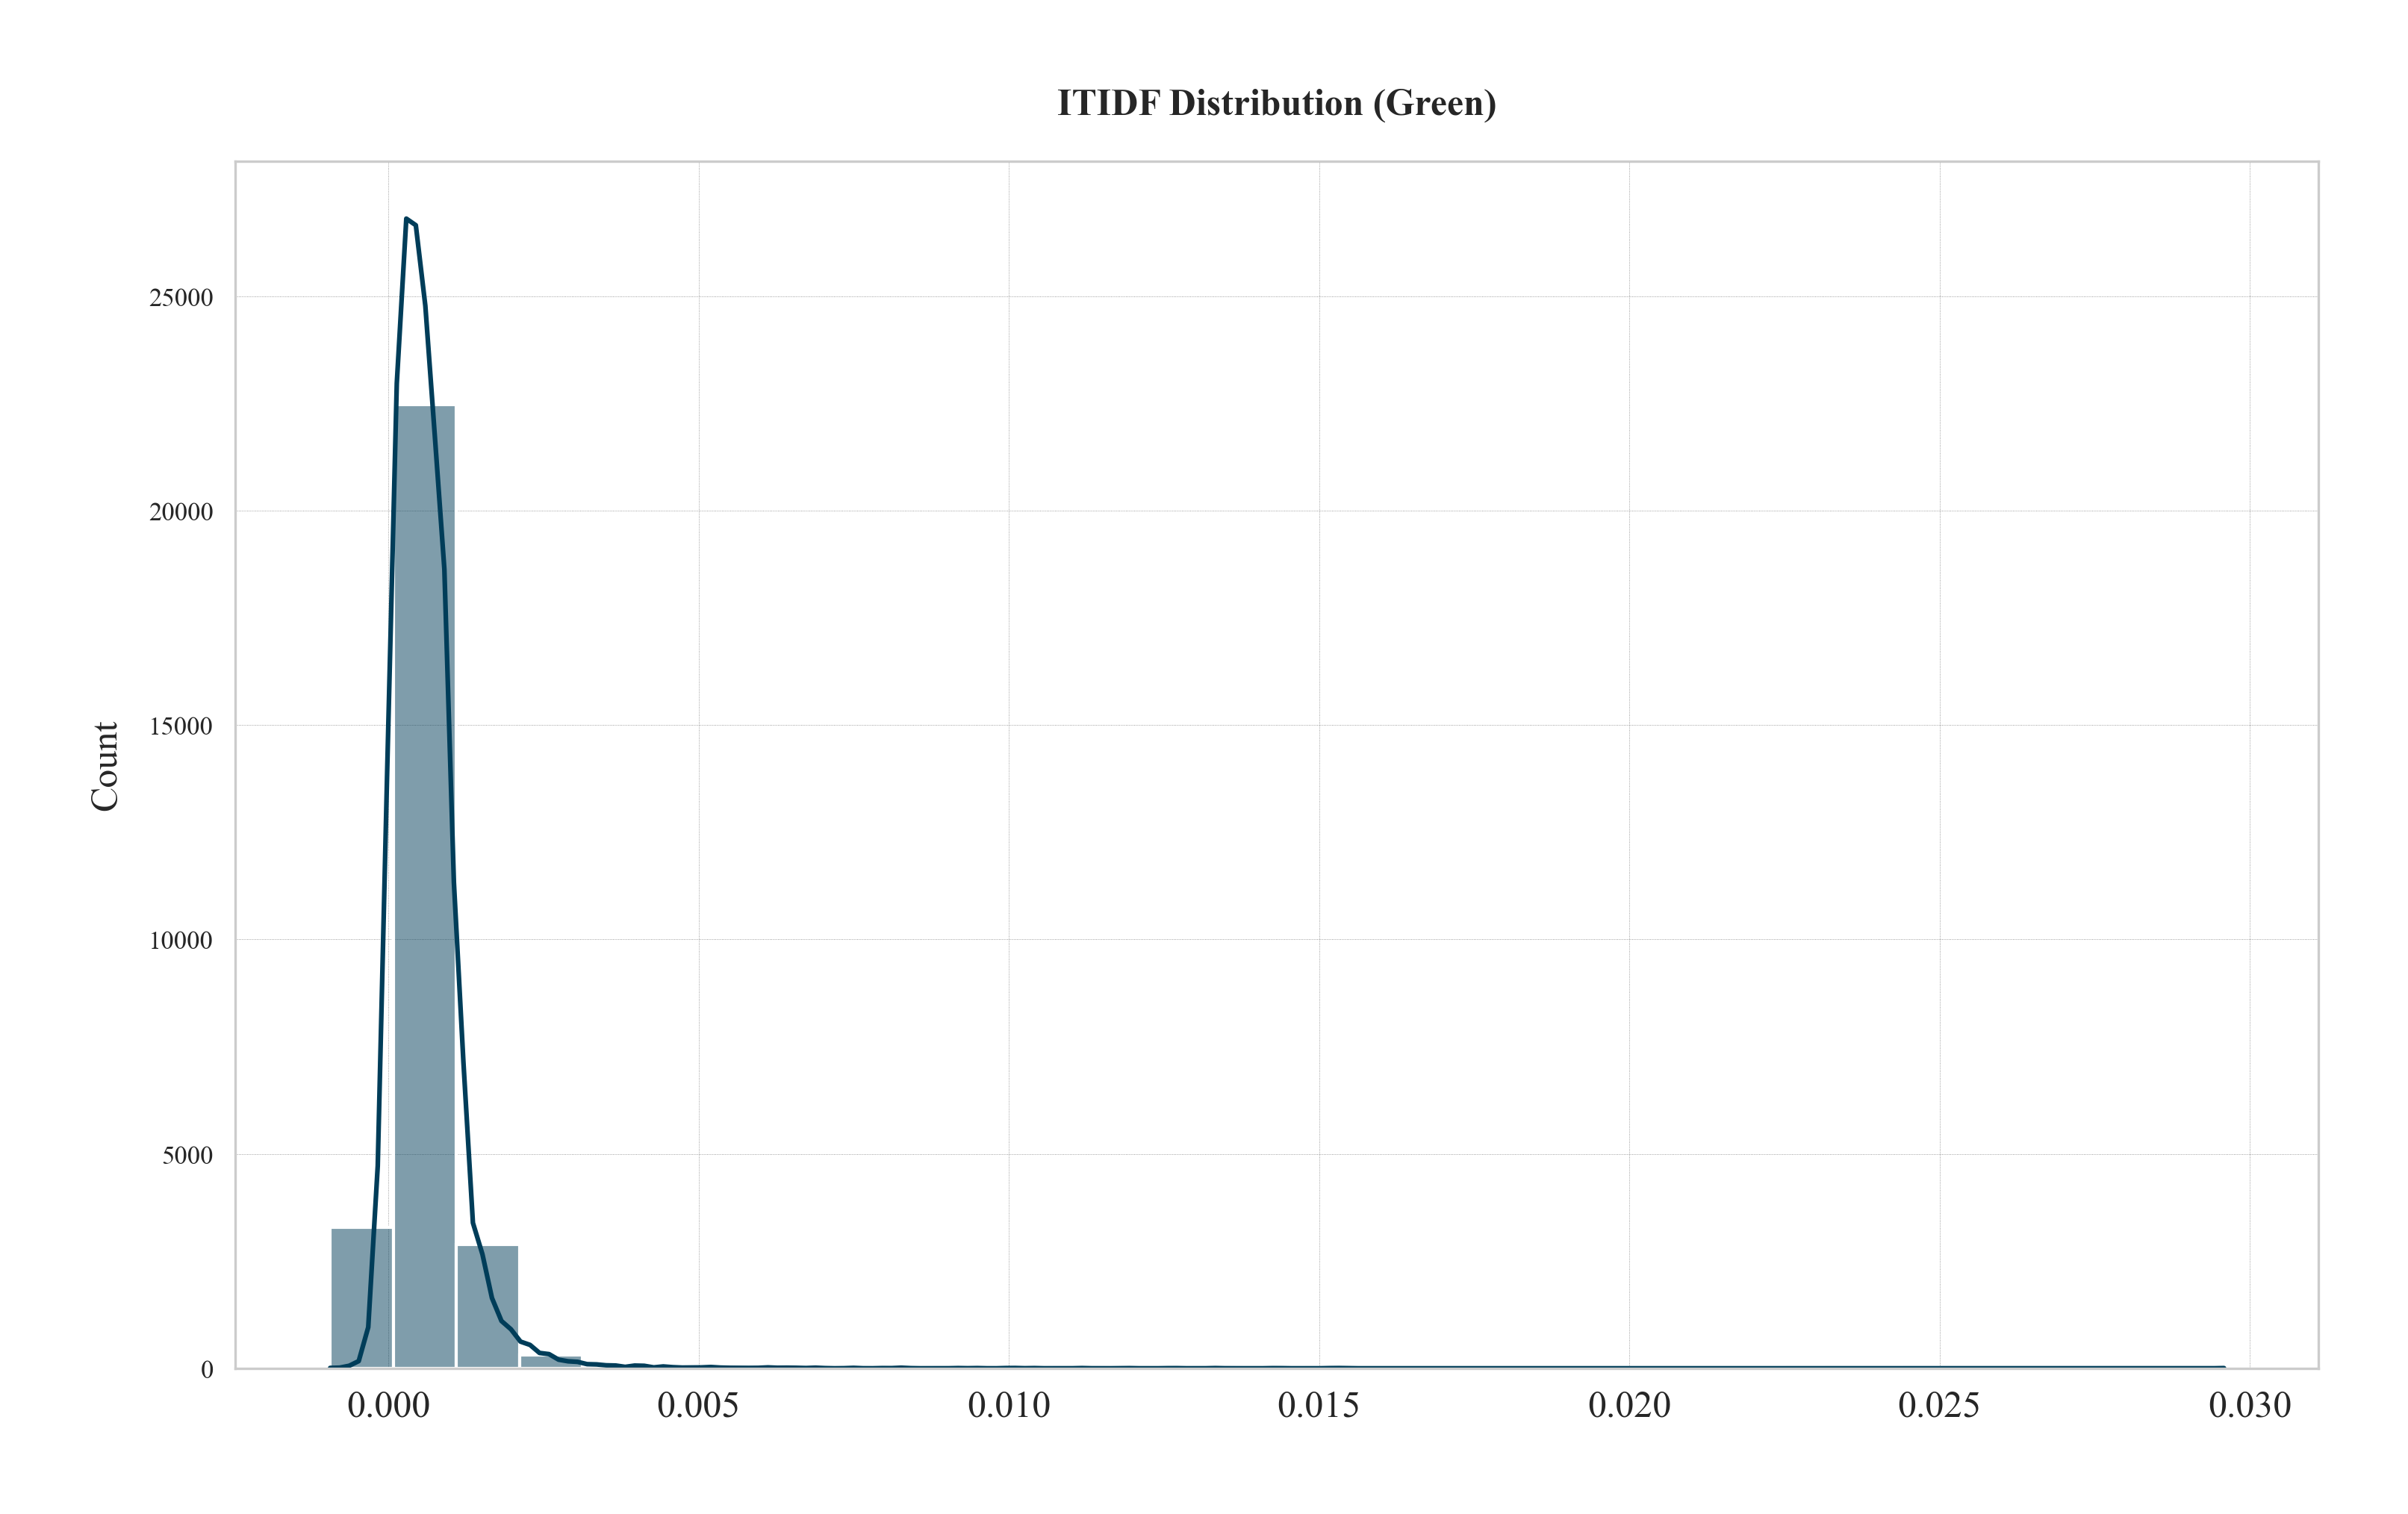

In [29]:
# Plot Q-Q plot and distribution for ITIDF values for Green
plot_qq(itidf_G, "Green")
plot_itidf_distribution(itidf_G, "Green")

In [30]:
from scipy.stats import shapiro
# Shapiro test for normality
def shapiro_test(data):
    """"
    Perform the Shapiro-Wilk test for normality from scipy.stats and print the results.

    Parameters:
    -----------
    data : list or array
        The data to be tested for normality.

    Returns: shapiro statistic and p-value

    """        
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk Test: p-value = {p}")

    if p > 0.05:
        print("Data appears to be normally distributed (fail to reject H0).")
    else:
        print("Data is not normally distributed (reject H0).")
    return stat, p

# Shapiro-Wilk test for normality
print("Wilson")
shapiro_test(itidf_W)
print("\n")
print("Green")
shapiro_test(itidf_G)

Wilson
Shapiro-Wilk Test: p-value = 1.9264430476087096e-105
Data is not normally distributed (reject H0).


Green
Shapiro-Wilk Test: p-value = 1.5939662570478783e-113
Data is not normally distributed (reject H0).


(np.float64(0.6885523258795925), np.float64(1.5939662570478783e-113))

**Why the Mann-Whitney U Test**

Since the data for the TF-IDF values is not normally distributed, a parametric test like the t-test is not appropriate. Instead, the Mann-Whitney U test is used, which is a non-parametric test for comparing two independent samples. It does not require the assumption of normality and is suitable for comparing distributions when the data is skewed or has outliers.

#### **Hypotheses:**
* Null Hypothesis (H₀): There is no significant difference in the TF-IDF values between the two translations (Wilson and Green).
* Alternative Hypothesis (H₁): There is a significant difference in the TF-IDF values between the two translations.

The Mann-Whitney U test evaluates whether the distributions of TF-IDF values for the two translations differ, considering their ranks rather than specific values.

In [31]:
# Mannwhitney U test for comparing ITIDF values
from scipy.stats import mannwhitneyu  # Import the actual function

def mannwhitneyu_test(x, y, alternative='two-sided'):
    """
    Perform the Mann-Whitney U test for comparing two independent samples.
    """
    stat, p = mannwhitneyu(x, y, alternative=alternative)  # Use SciPy's function
    print(f"Mann-Whitney U test statistic: {stat}, p-value: {p}")

    if p < 0.05:
        print("Reject H₀: The distributions of the translations are significantly different.")
    else:
        print("Fail to reject H₀: No significant difference between the translations.")

# Run the test
mannwhitneyu_test(itidf_W, itidf_G, alternative='two-sided')

Mann-Whitney U test statistic: 398451440.5, p-value: 2.3169071909419926e-146
Reject H₀: The distributions of the translations are significantly different.


____________________________________________________
## 5️⃣ Discussion of Results  

After the three experiments and various statistical tests for each, it has been stablished, with statistical certainty, that lexicaly the translations maintain and analogous diversity. this fact supports the argument of a strong cultural sway in their translations. The sample of the present MVP analysis is too small to conclude with certainty anything, however, it proves that the method works and yields interesting insights.

### 🔎 **Findings:** Insights from experiments. 
* 
* 
* 
* Explanation:
	•	Test Statistic: The Mann-Whitney U test statistic of 398451440.5 is the computed value from comparing the two distributions.
	•	P-value: The p-value of 2.3169071909419926e-146 is extremely small (much smaller than the typical threshold of 0.05). This indicates strong evidence against the null hypothesis (H₀).

Conclusion:

Since the p-value is significantly less than 0.05, we reject the null hypothesis (H₀). This means that the result supports the alternative hypothesis (H₁), which states that the distributions of TF-IDF values for the two translations are significantly different.

Therefore, the result is consistent with the hypothesis that there is a significant difference between the two translations’ TF-IDF values.



### 🚀 **New Directions:** Refinements & future research steps.  
🔍 **Future Research Directions**

To expand this analysis, further studies could explore:

📖 Lexical Choices – Examining connotations, archaisms, or modernisms.
📝 Syntactic Complexity – Analyzing sentence length, clause structure, and variation.
🌏 Cross-Temporal & Cross-Cultural Comparisons – Investigating how different eras or languages shape translation style.
👥 Reader Reception – Assessing whether lexical diversity affects comprehension and literary appreciation.

